# 01 - reanalysis

We took the original `FASTQ` files from [GSE200534](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE200534) and preprocessed them using `nf-core/marsseq` pipeline.

```bash
nextflow run ...
```

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

import glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from natsort import natsorted
from matplotlib import rcParams

random_seed = 12345
np.random.seed(random_seed)
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3

In [2]:
def ignore_n_rows(csv_file):
    with open(csv_file) as f:
        for index, line in enumerate(f):
            if line.startswith("Well"):
                return index
        return 0


def load_metadata():
    metadata = pd.read_excel(
        "../data/raw/Design file_Sara_Corrected_plusColumn.xlsx",
        usecols=range(1, 20),
        index_col=0,
    )
    facs_data = []
    for csv_file in metadata["Index sort"].unique():
        print(f"Processing {csv_file}")
        file: str = f"../data/raw/facs-data/{csv_file}.csv"
        skip_rows = ignore_n_rows(file)
        csv_content = pd.read_csv(file, skiprows=skip_rows, index_col=0, thousands=",")
        csv_content.columns = csv_content.columns.str.strip().str.replace(" ", ".")
        csv_content = csv_content[
            [
                "All.Events.FSC-A.Geo.Mean",
                "All.Events.SSC-A.Geo.Mean",
                "All.Events.GFP-A.Geo.Mean",
                "All.Events.mCherry.561D-A.Geo.Mean",
                "All.Events.DAPI-A.Geo.Mean",
            ]
        ]
        csv_content = csv_content.astype(float)

        design_sub = metadata[metadata["Index sort"] == csv_file]
        design_merged = design_sub.merge(
            csv_content, left_on="Well_coordinates", right_index=True, how="left"
        )
        facs_data.append(design_merged)
    facs_data = pd.concat(facs_data, sort=False)

    # fix proper order
    facs_data = facs_data.loc[natsorted(facs_data.index)]

    facs_data = facs_data[
        [
            "Well_coordinates",
            "plate_ID",
            "Amp_batch_ID",
            "Cell_barcode",
            "Pool_barcode",
            "Batch",
            "Condition",
            "SampleName",
            "Stage",
            "Source",
            "Day",
            "Index sort",
            "All.Events.FSC-A.Geo.Mean",
            "All.Events.SSC-A.Geo.Mean",
            "All.Events.GFP-A.Geo.Mean",
            "All.Events.mCherry.561D-A.Geo.Mean",
            "All.Events.DAPI-A.Geo.Mean",
        ]
    ]

    return facs_data

# Create object

In [3]:
sb_1 = natsorted(glob.glob('../data/raw/SB1/umi.tab/*'))
sb_2 = natsorted(glob.glob('../data/raw/SB2/umi.tab/*'))

batch_files = np.concatenate([sb_1, sb_2])
counts = pd.concat([pd.read_table(x) for x in batch_files], axis=1)

In [4]:
facs_content = load_metadata()

Processing Plate 1A_2iLIF
Processing Plate 2A_D0_2iLIF
Processing Plate 2A_D0_rest
Processing Plate 3B_D1_2iLIF
Processing Plate 3B_D1_rest
Processing Plate 4A_D2_2iLIF
Processing Plate 4A_D2_rest
Processing Plate 5A_D3_2iLIF
Processing Plate 5A_D3_rest
Processing Plate 6A_D4_2iLIF
Processing Plate 6A_D4_rest
Processing Plate 7A_D7_2iLIF
Processing Plate 7A_D7_rest


In [5]:
adata = sc.AnnData(X=counts.T, obs=facs_content)
adata.obs['plate_ID'] = adata.obs['plate_ID'].astype('category')
adata

AnnData object with n_obs × n_vars = 2496 × 53638
    obs: 'Well_coordinates', 'plate_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'Day', 'Index sort', 'All.Events.FSC-A.Geo.Mean', 'All.Events.SSC-A.Geo.Mean', 'All.Events.GFP-A.Geo.Mean', 'All.Events.mCherry.561D-A.Geo.Mean', 'All.Events.DAPI-A.Geo.Mean'

# FACS

(-1000.0, 4200.0)

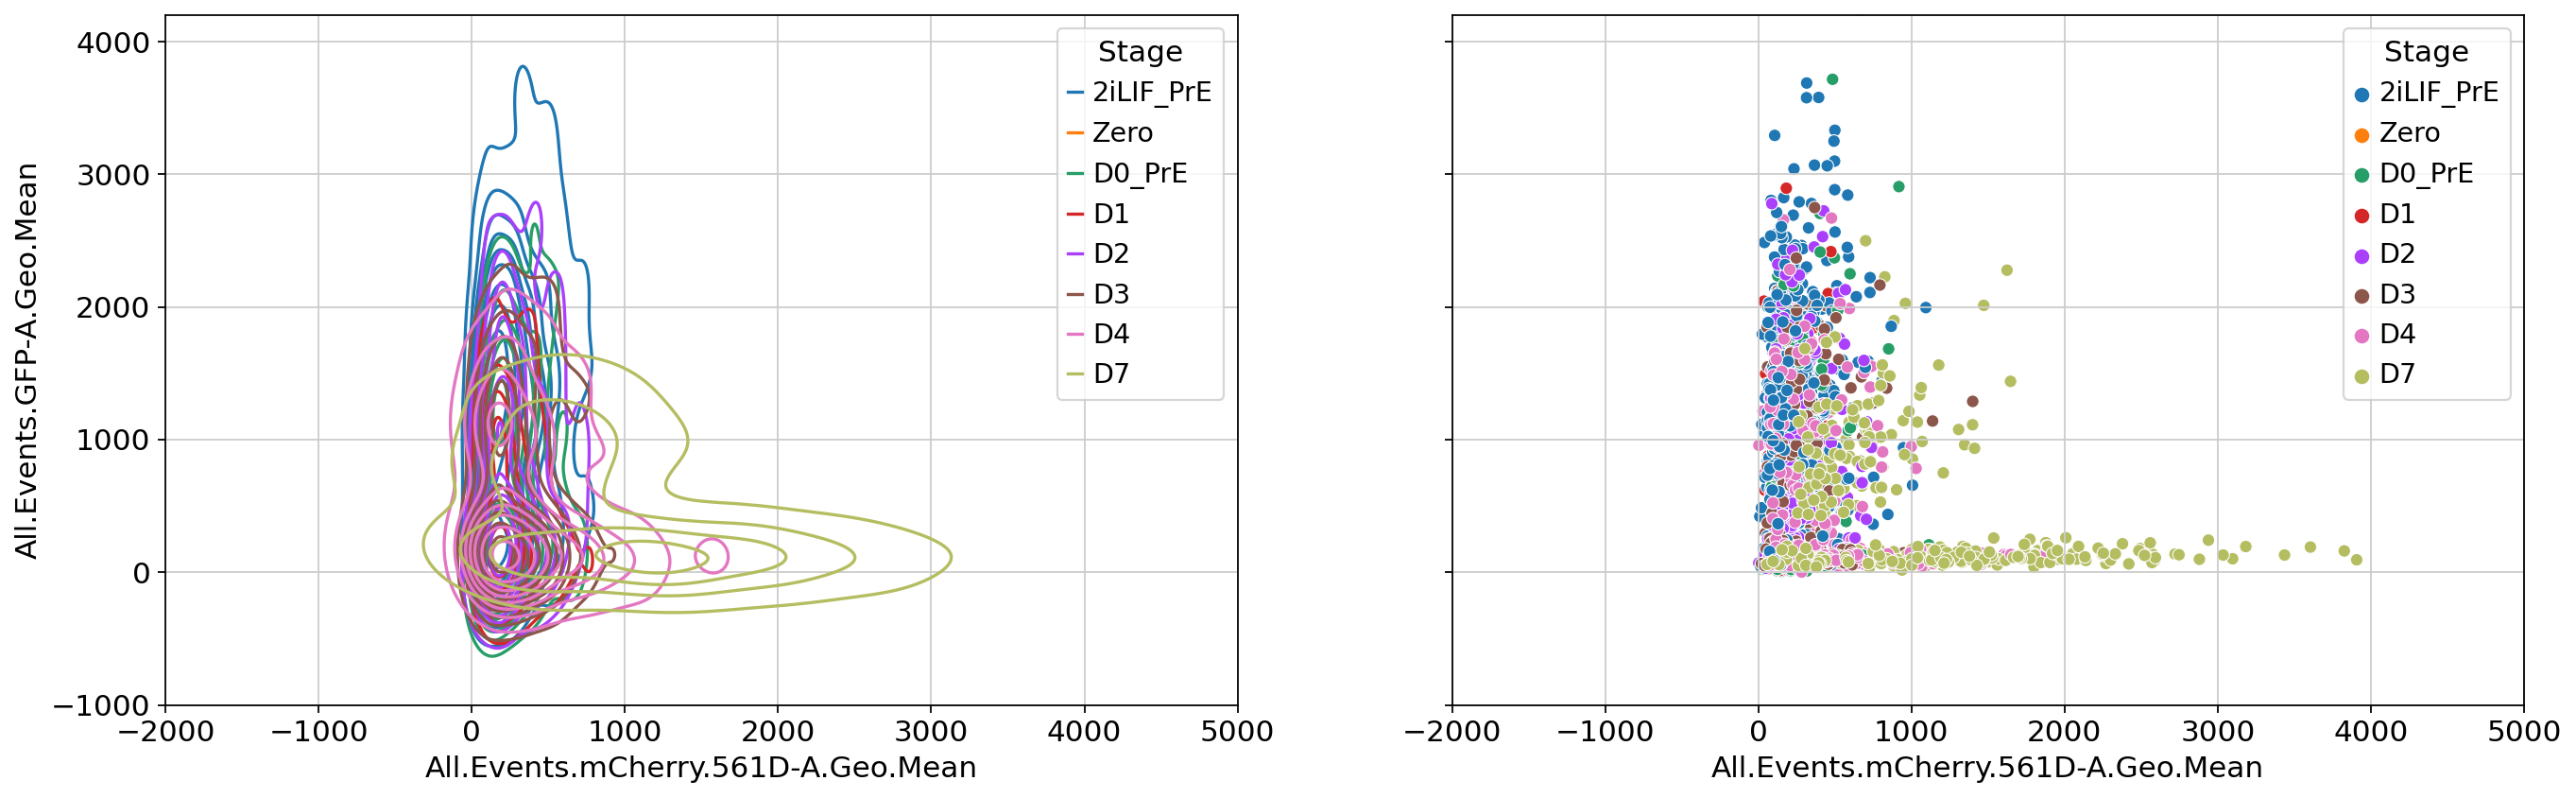

In [6]:
fig, ax = plt.subplots(1, 2, figsize=[20, 6], sharey=True, sharex=True)
sns.kdeplot(x='All.Events.mCherry.561D-A.Geo.Mean', y='All.Events.GFP-A.Geo.Mean', hue='Stage', data=adata.obs, ax=ax[0])
sns.scatterplot(x='All.Events.mCherry.561D-A.Geo.Mean', y='All.Events.GFP-A.Geo.Mean', hue='Stage', data=adata.obs, ax=ax[1])

plt.xlim(-2_000, 5_000)
plt.ylim(-1_000, 4_200)

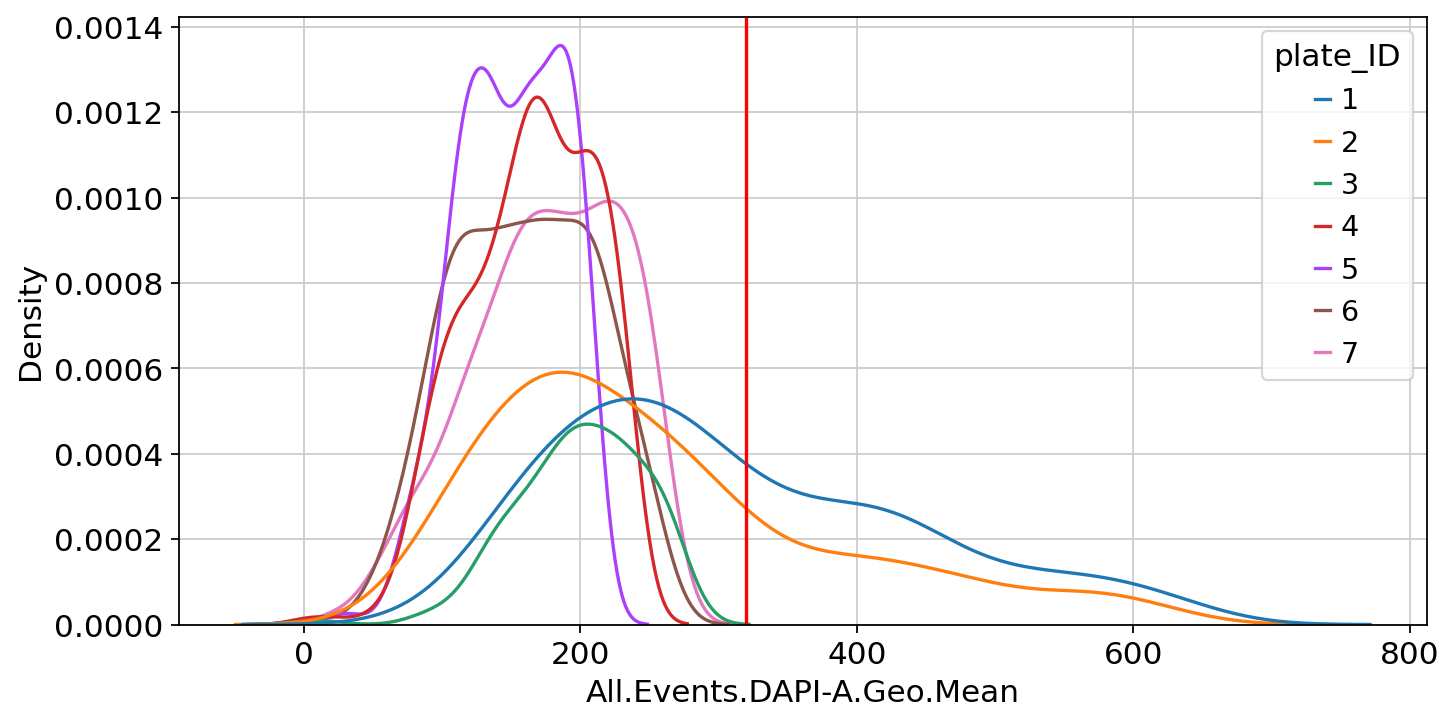

In [7]:
rcParams['figure.figsize'] = 10, 5
sns.kdeplot(x='All.Events.DAPI-A.Geo.Mean', hue='plate_ID', data=adata.obs)
plt.axvline(x=320, color='r')

In [8]:
adata.obs[['plate_ID', 'All.Events.DAPI-A.Geo.Mean']].groupby('plate_ID').describe()

All.Events.DAPI-A.Geo.Mean                                        \
                              count        mean         std   min     25%   
plate_ID                                                                    
1                             380.0  312.076316  129.469802  74.0  211.75   
2                             373.0  257.021448  126.962295  67.0  170.00   
3                             143.0  199.748252   45.764933   8.0  168.50   
4                             379.0  164.749340   45.180566   2.0  133.00   
5                             377.0  150.339523   37.621242  24.0  121.00   
6                             378.0  159.735450   51.429578   5.0  117.00   
7                             380.0  176.439474   53.891458  17.0  141.75   

                               
            50%    75%    max  
plate_ID                       
1         282.5  401.0  653.0  
2         226.0  314.0  630.0  
3         201.0  233.5  271.0  
4         169.0  202.5  236.0  
5         153.0  182.0  214.0  
6         161.0  203.0  260.0  
7         180.5  221.0  259.0

# Filtering

In [9]:
# adata = adata[adata.obs.plate_ID != 1]
adata = adata[adata.obs['All.Events.DAPI-A.Geo.Mean'] <= 320.0]
adata = adata[adata.obs.Stage != 'Zero']

In [10]:
adata.obs[['plate_ID', 'All.Events.DAPI-A.Geo.Mean']].groupby('plate_ID').describe()

All.Events.DAPI-A.Geo.Mean                                       \
                              count        mean        std   min     25%   
plate_ID                                                                   
1                             227.0  222.933921  54.505338  74.0  182.50   
2                             286.0  198.164336  62.649436  67.0  150.25   
3                             143.0  199.748252  45.764933   8.0  168.50   
4                             379.0  164.749340  45.180566   2.0  133.00   
5                             377.0  150.339523  37.621242  24.0  121.00   
6                             378.0  159.735450  51.429578   5.0  117.00   
7                             380.0  176.439474  53.891458  17.0  141.75   

                                
            50%     75%    max  
plate_ID                        
1         226.0  267.50  320.0  
2         191.5  246.75  320.0  
3         201.0  233.50  271.0  
4         169.0  202.50  236.0  
5         153.0  182.00  214.0  
6         161.0  203.00  260.0  
7         180.5  221.00  259.0

In [11]:
adata.shape

(2170, 53638)

In [12]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['ercc'] = adata.var_names.str.startswith('ERCC-')
adata.var['ribo'] = adata.var_names.str.startswith(('Rpl', 'Rps'))

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ercc', 'ribo'], percent_top=None, log1p=False, inplace=True)

Trying to set attribute `.var` of view, copying.


<AxesSubplot:ylabel='pct_counts_ercc'>

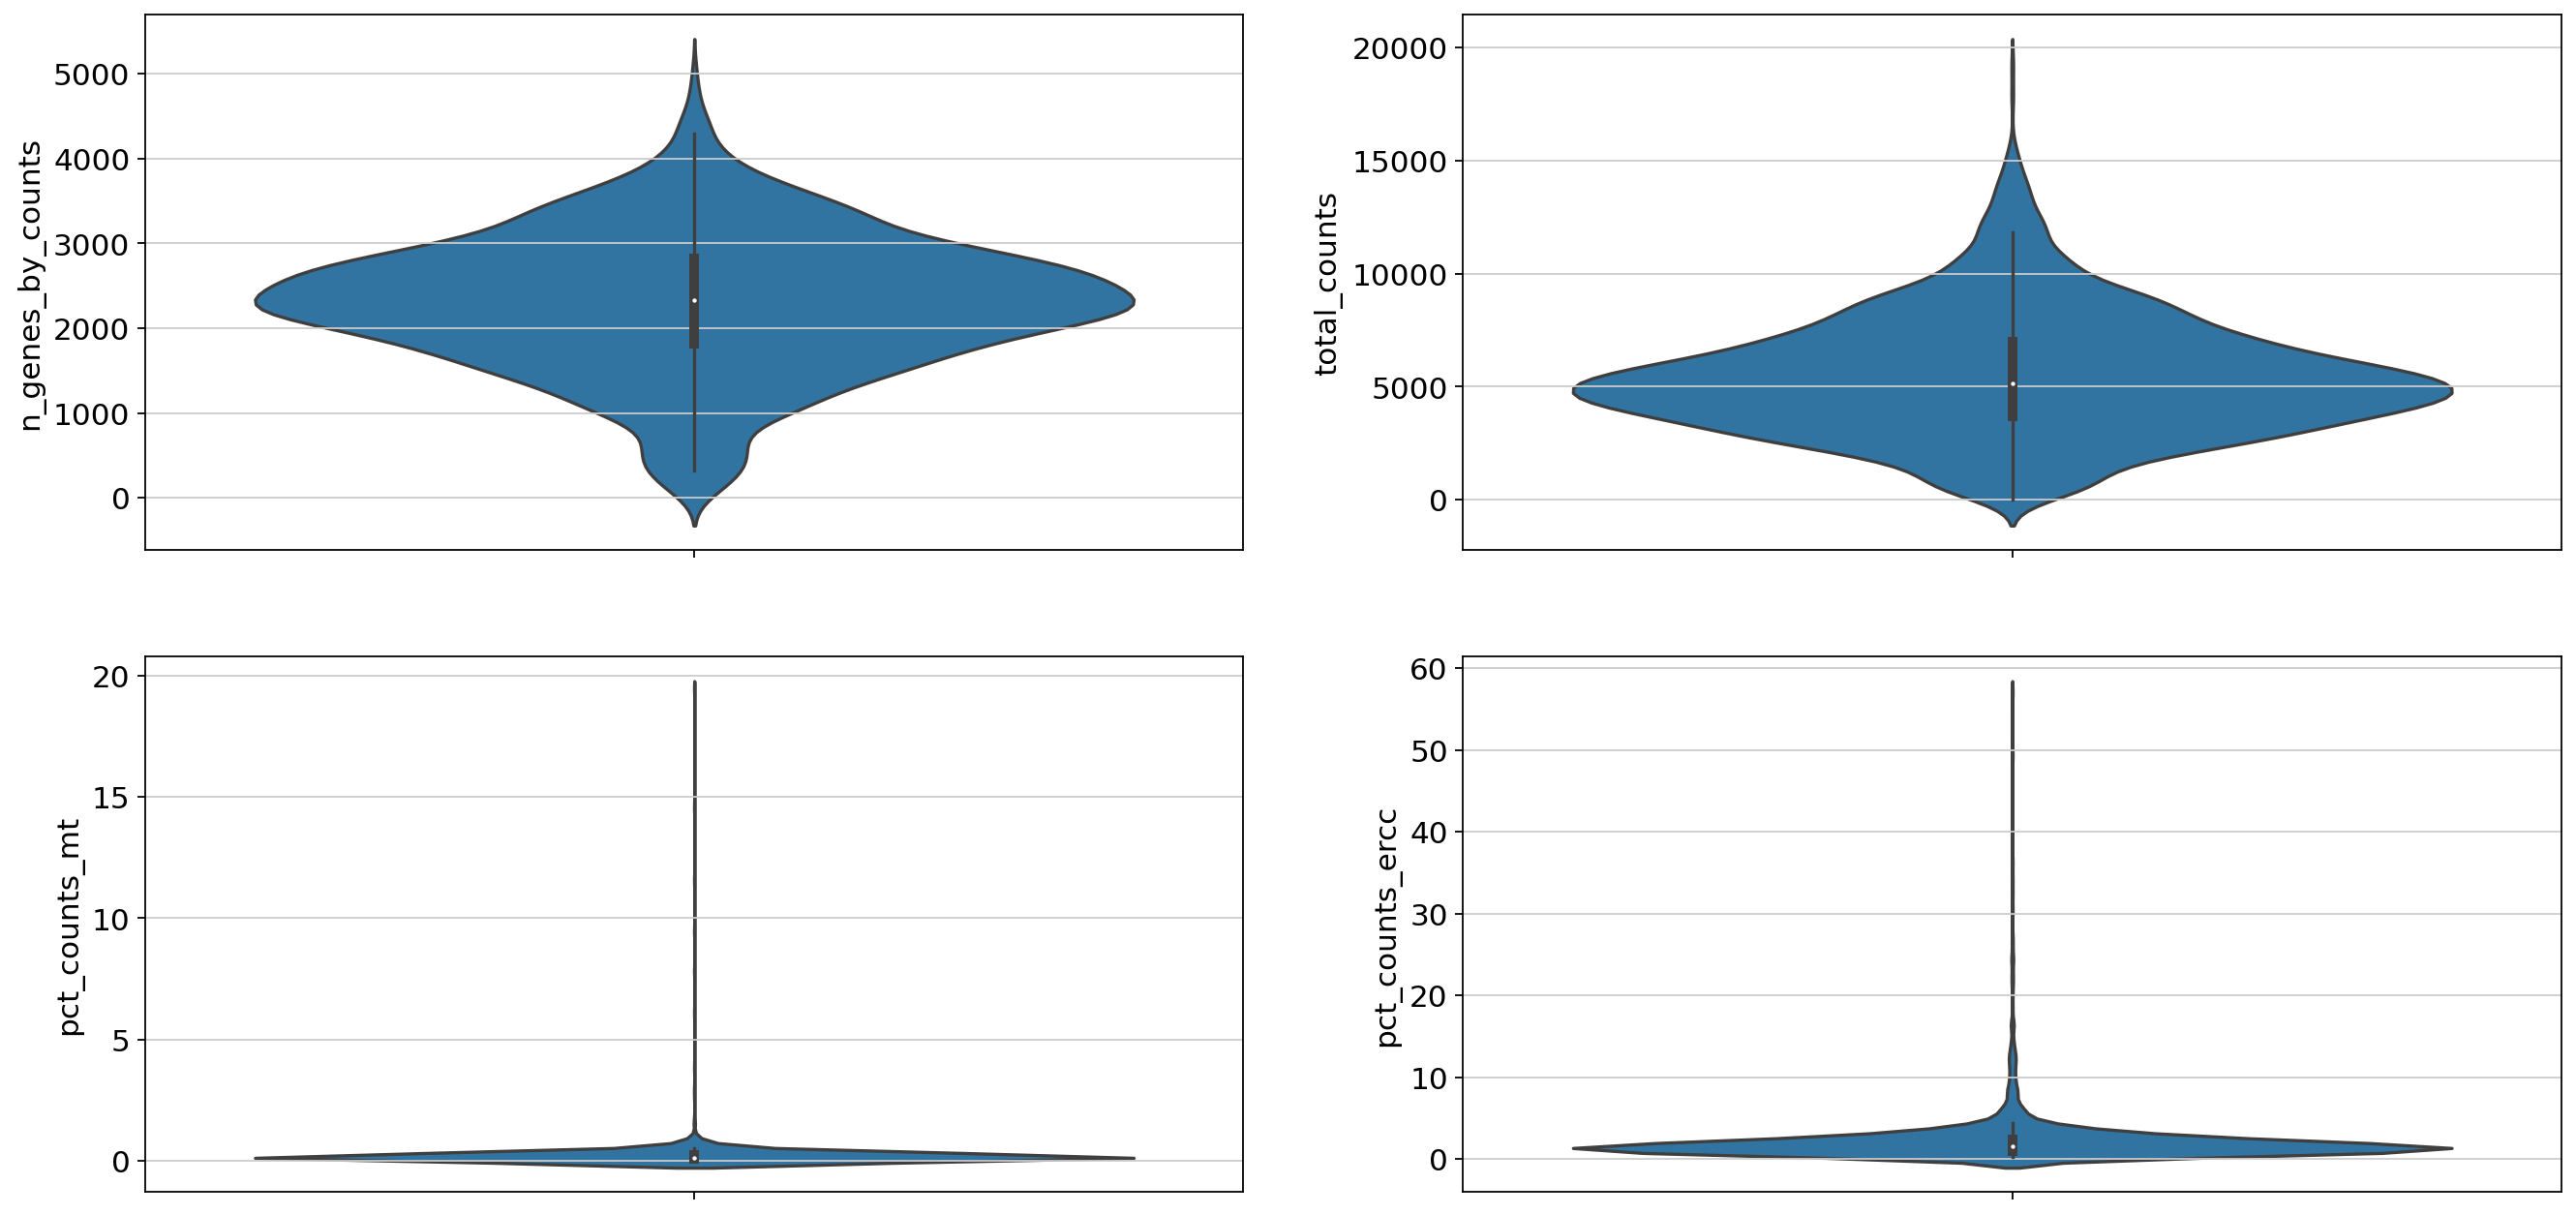

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.violinplot(y=adata.obs['n_genes_by_counts'], orient='v', ax=ax[0][0])
sns.violinplot(y=adata.obs['total_counts'], orient='v', ax=ax[0][1])
sns.violinplot(y=adata.obs['pct_counts_mt'], orient='v', ax=ax[1][0])
sns.violinplot(y=adata.obs['pct_counts_ercc'], orient='v', ax=ax[1][1])

<AxesSubplot:xlabel='total_counts', ylabel='n_genes_by_counts'>

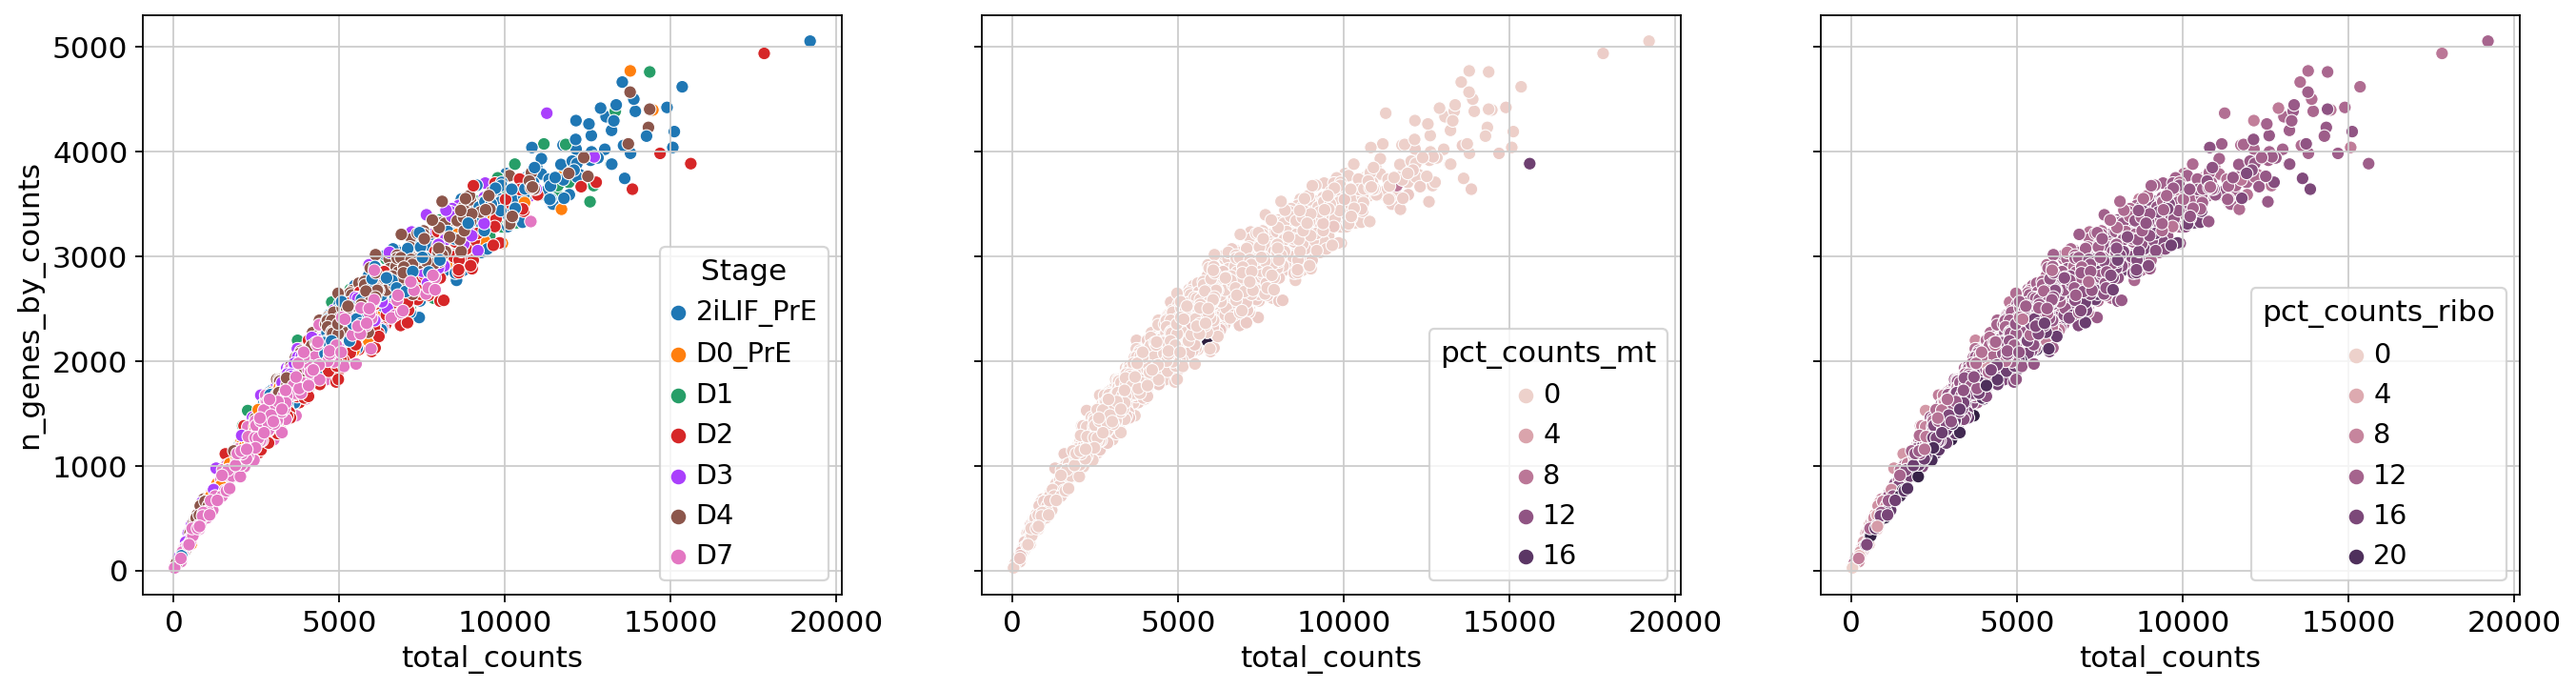

In [14]:
fig, ax = plt.subplots(1,3, figsize=(20, 5), sharey=True)
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[0], data=adata.obs, hue='Stage')
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[1], hue='pct_counts_mt', data=adata.obs)
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[2], hue='pct_counts_ribo', data=adata.obs)

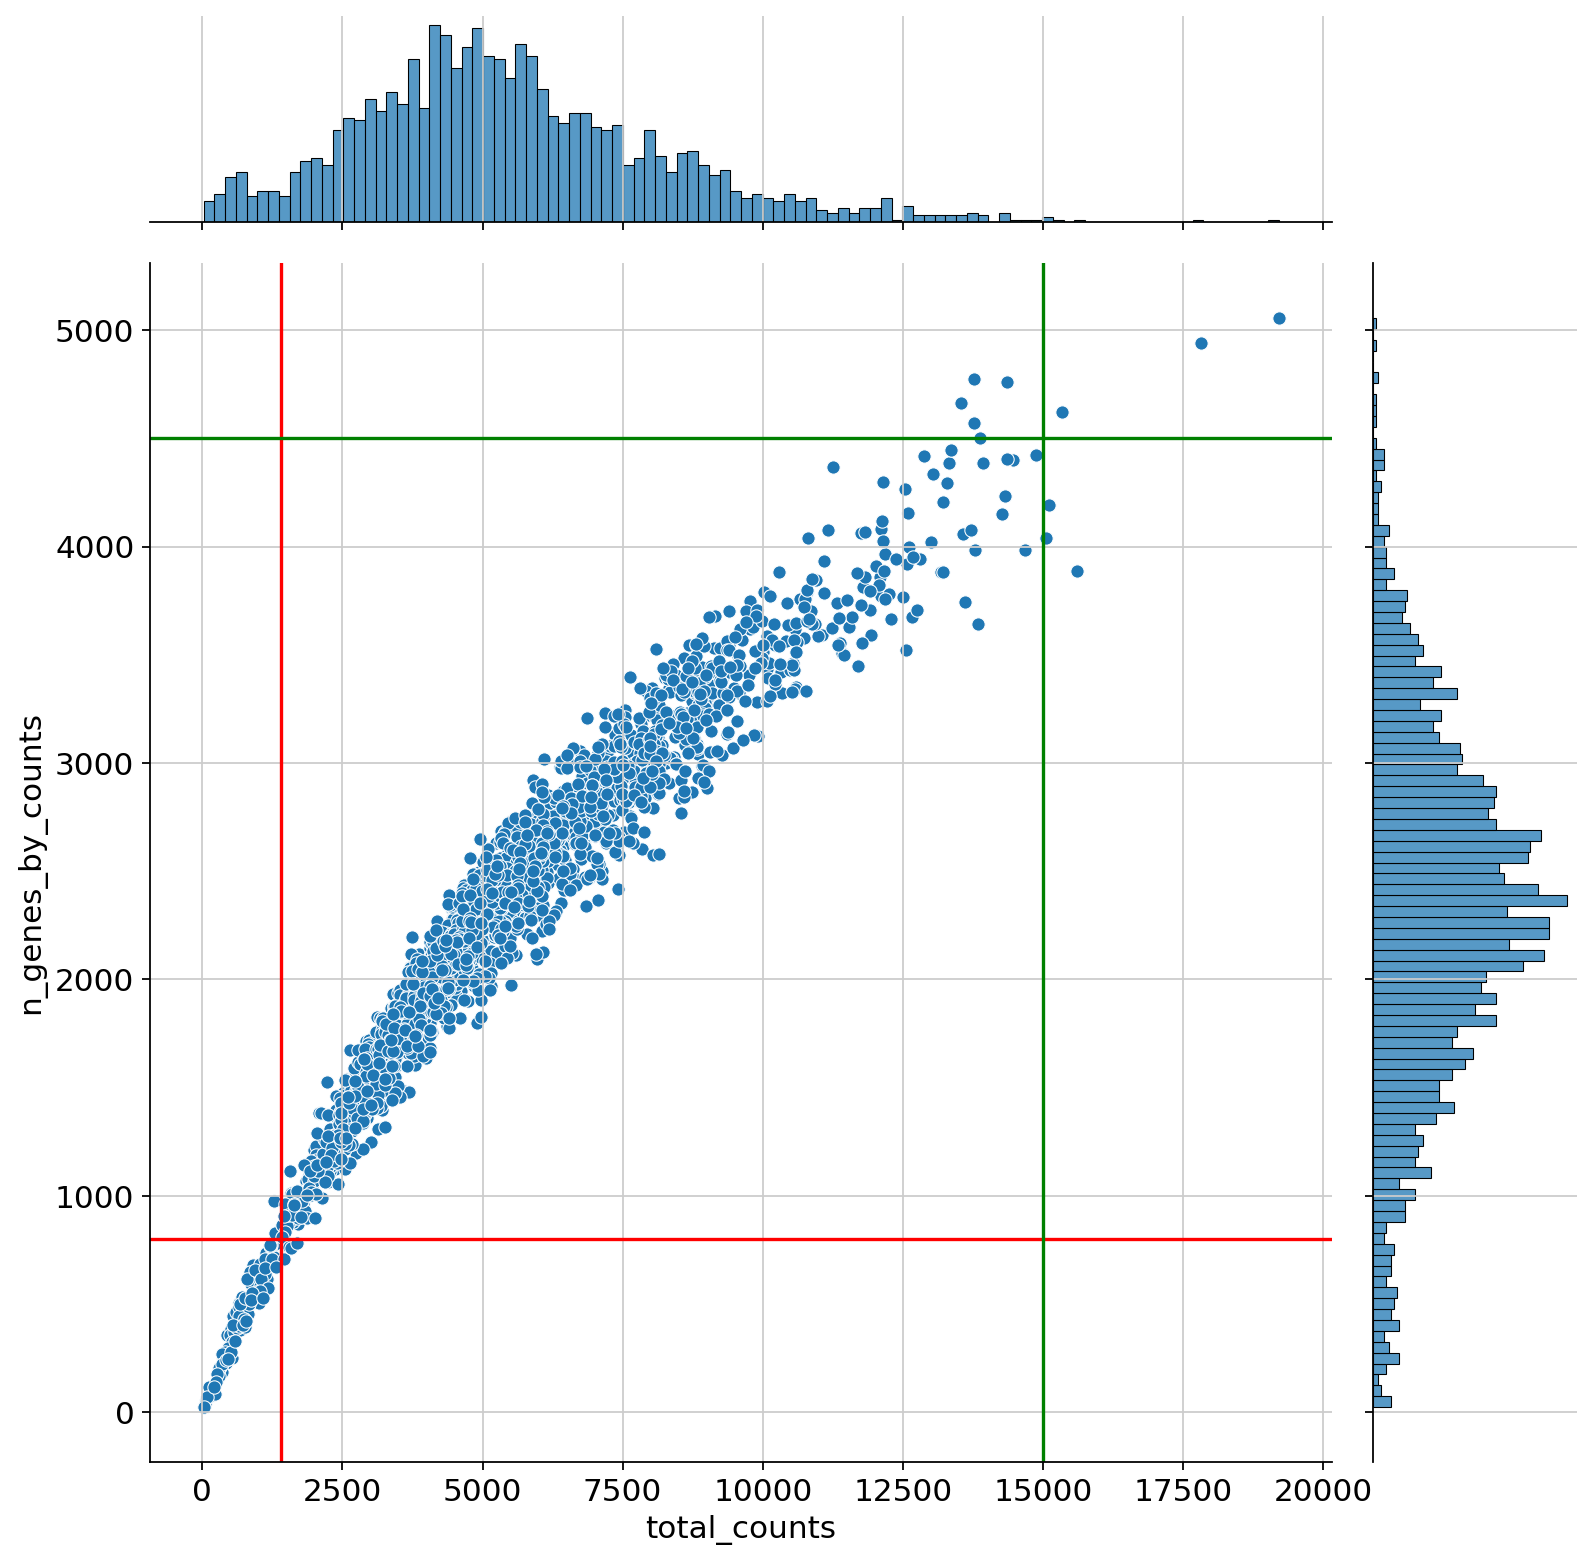

In [15]:
min_cells, max_cells = 1_400, 15_000
min_genes, max_genes = 800, 4_500

p = sns.jointplot(x='total_counts', y='n_genes_by_counts', data=adata.obs, marginal_kws=dict(bins=100), height=10)
# min
p.ax_joint.axvline(x=min_cells, color='red')
p.ax_joint.axhline(y=min_genes, color='red')

# max
p.ax_joint.axvline(x=max_cells, color='green')
p.ax_joint.axhline(y=max_genes, color='green')

In [16]:
print(f'Before filtering: {adata.shape}')

# Remove ERCC cells
adata = adata[:, ~adata.var_names.str.startswith('ERCC-')]

sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_cells(adata, min_counts=min_cells)
sc.pp.filter_cells(adata, max_counts=max_cells)
sc.pp.filter_cells(adata, max_genes=max_genes)

sc.pp.filter_genes(adata, min_cells=3)
print(f'After filtering: {adata.shape}')

Before filtering: (2170, 53638)
filtered out 100 cells that have less than 800 genes expressed


Trying to set attribute `.obs` of view, copying.


filtered out 6 cells that have less than 1400 counts
filtered out 5 cells that have more than 15000 counts
filtered out 4 cells that have more than 4500 genes expressed
filtered out 33087 genes that are detected in less than 3 cells
After filtering: (2055, 20459)


<AxesSubplot:ylabel='pct_counts_ribo'>

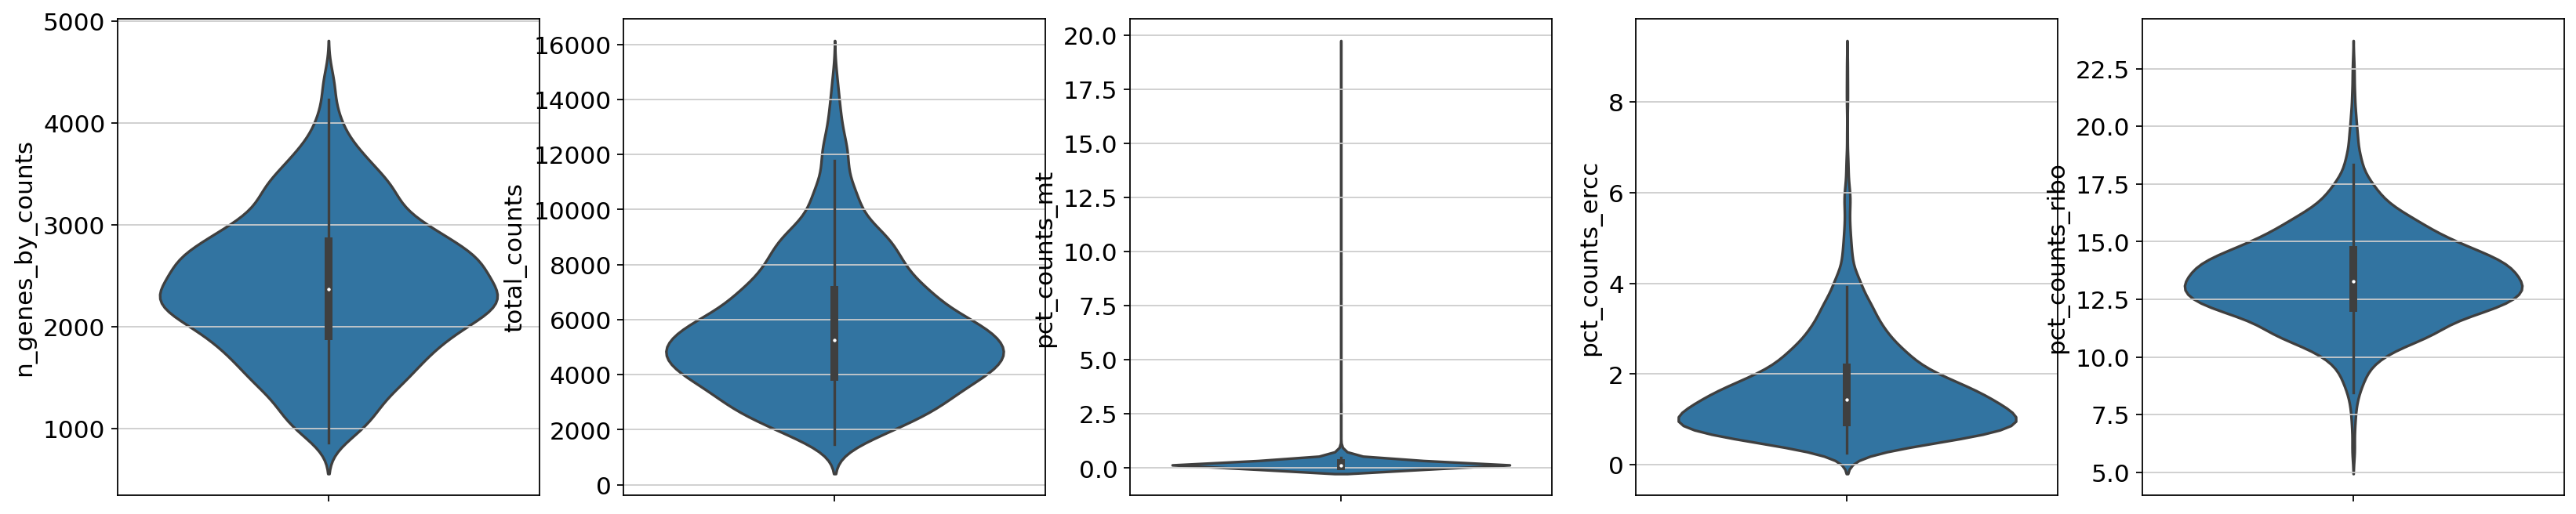

In [17]:
fig, ax = plt.subplots(1,5, figsize=(25, 5))
sns.violinplot(y=adata.obs['n_genes_by_counts'], orient='v', ax=ax[0])
sns.violinplot(y=adata.obs['total_counts'], orient='v', ax=ax[1])
sns.violinplot(y=adata.obs['pct_counts_mt'], orient='v', ax=ax[2])
sns.violinplot(y=adata.obs['pct_counts_ercc'], orient='v', ax=ax[3])
sns.violinplot(y=adata.obs['pct_counts_ribo'], orient='v', ax=ax[4])

In [18]:
adata.layers['raw'] = adata.X.copy()

# Normalize

In [19]:
sc.pp.normalize_total(adata, target_sum=10_000)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


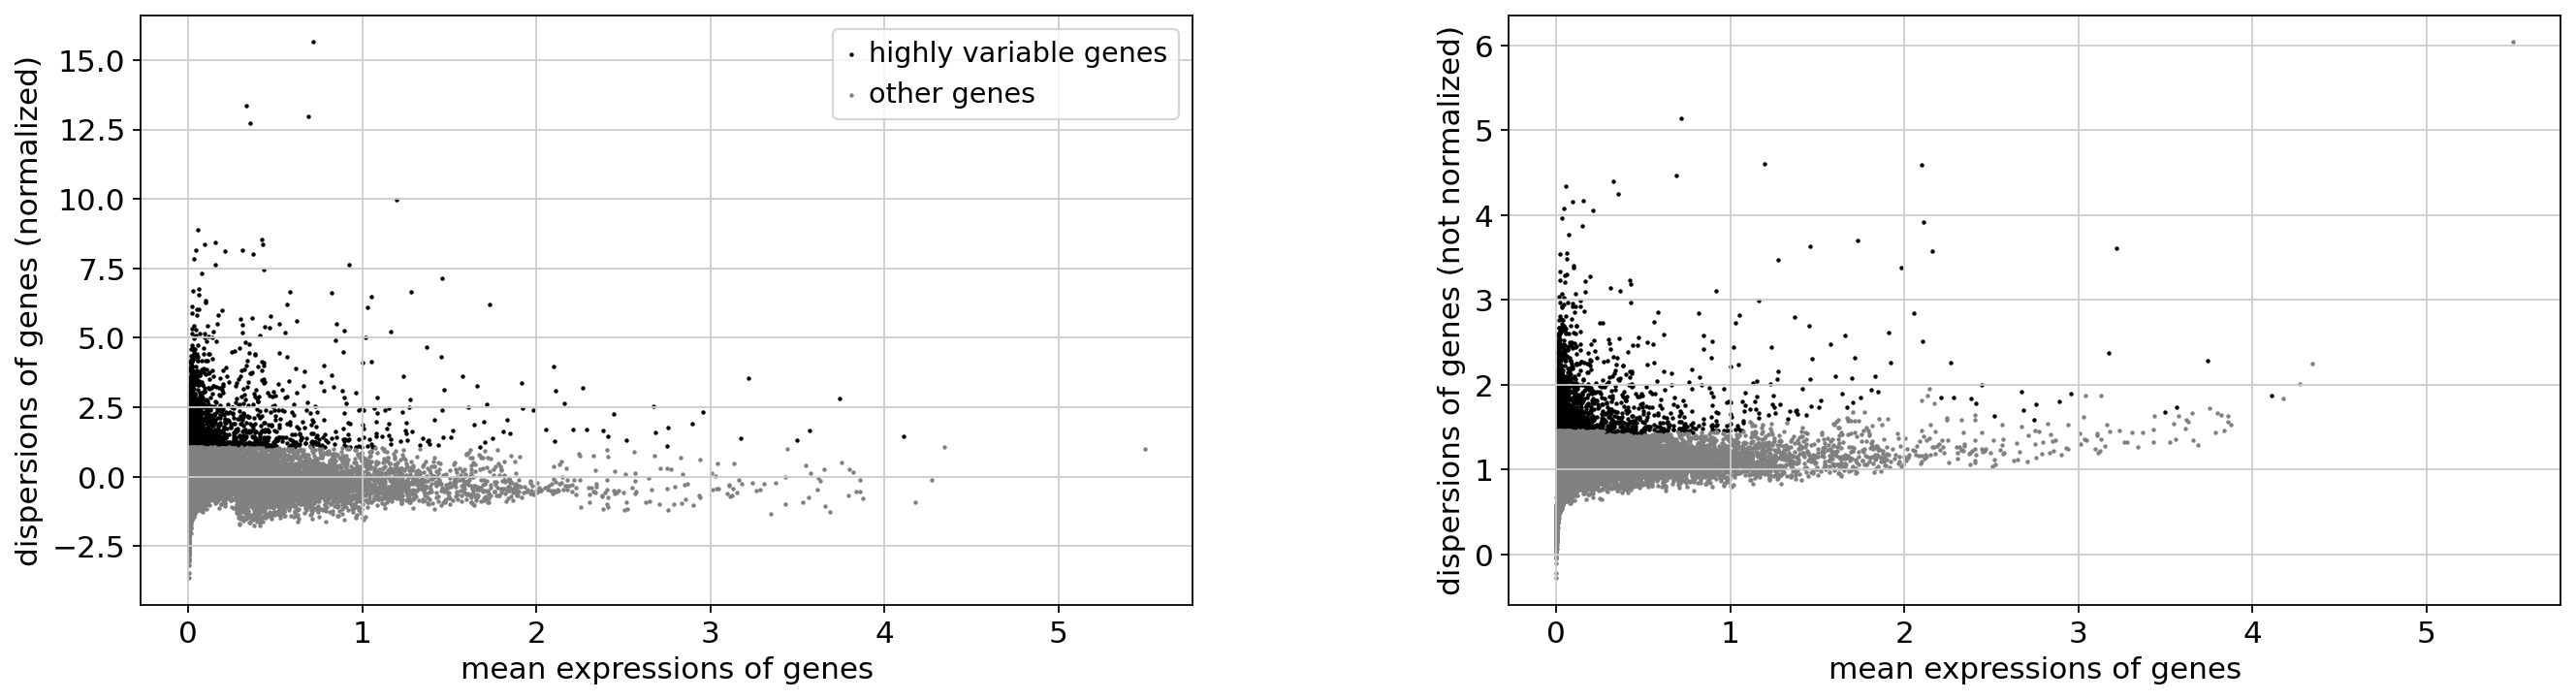

In [20]:
sc.pp.highly_variable_genes(adata, n_top_genes=2_000)
sc.pl.highly_variable_genes(adata)

In [21]:
sc.pp.scale(adata, max_value=5)

In [22]:
cc_genes = pd.read_table("https://raw.githubusercontent.com/theislab/single-cell-tutorial/master/Macosko_cell_cycle_genes.txt", delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_hvg = adata.var_names[np.in1d(adata.var_names, s_genes_mm)]
g2m_genes_hvg = adata.var_names[np.in1d(adata.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_hvg, g2m_genes=g2m_genes_hvg)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    1765 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    1772 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [23]:
adata.obs.phase.value_counts()

G2M    1349
S       515
G1      191
Name: phase, dtype: int64

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


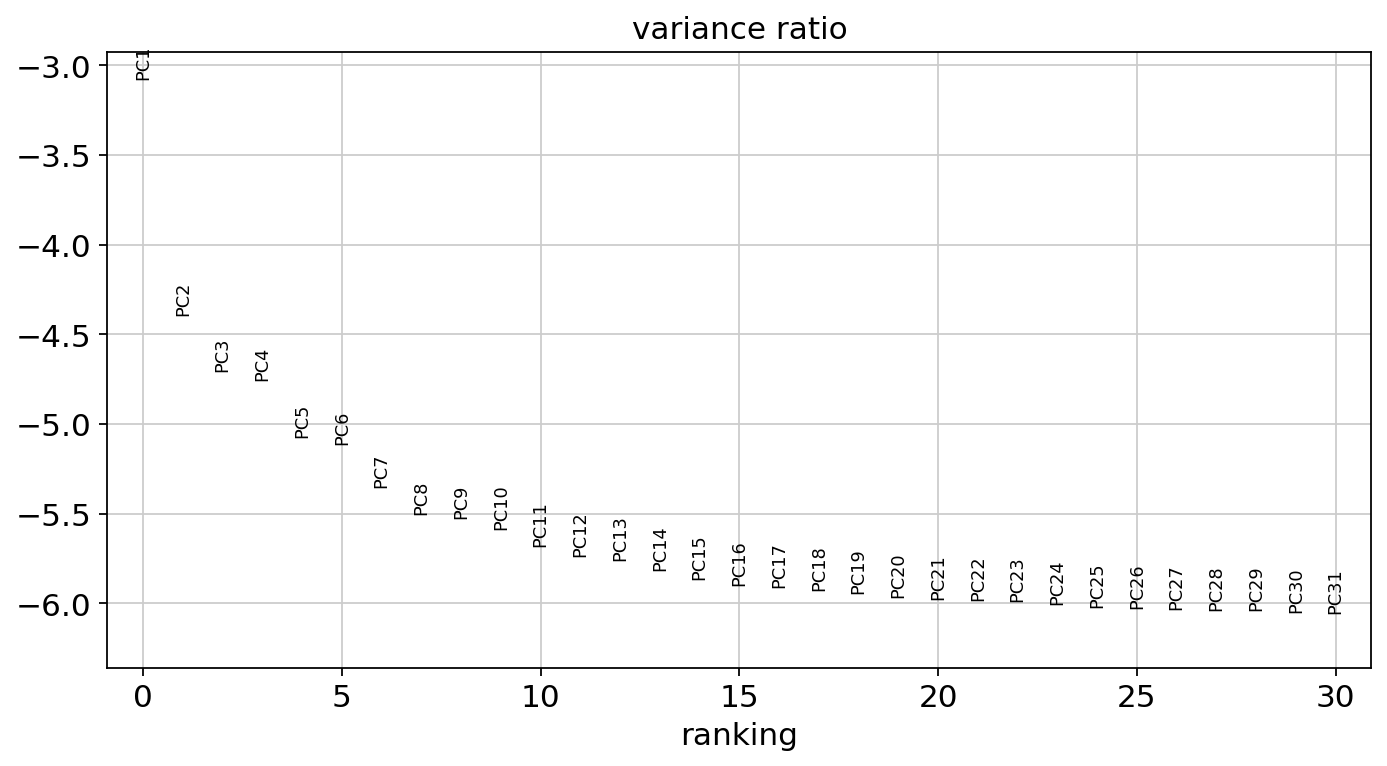

In [24]:
sc.tl.pca(adata, svd_solver='arpack', random_state=random_seed)
sc.pl.pca_variance_ratio(adata, log=True)

... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'Day' as categorical
... storing 'Index sort' as categorical
... storing 'phase' as categorical


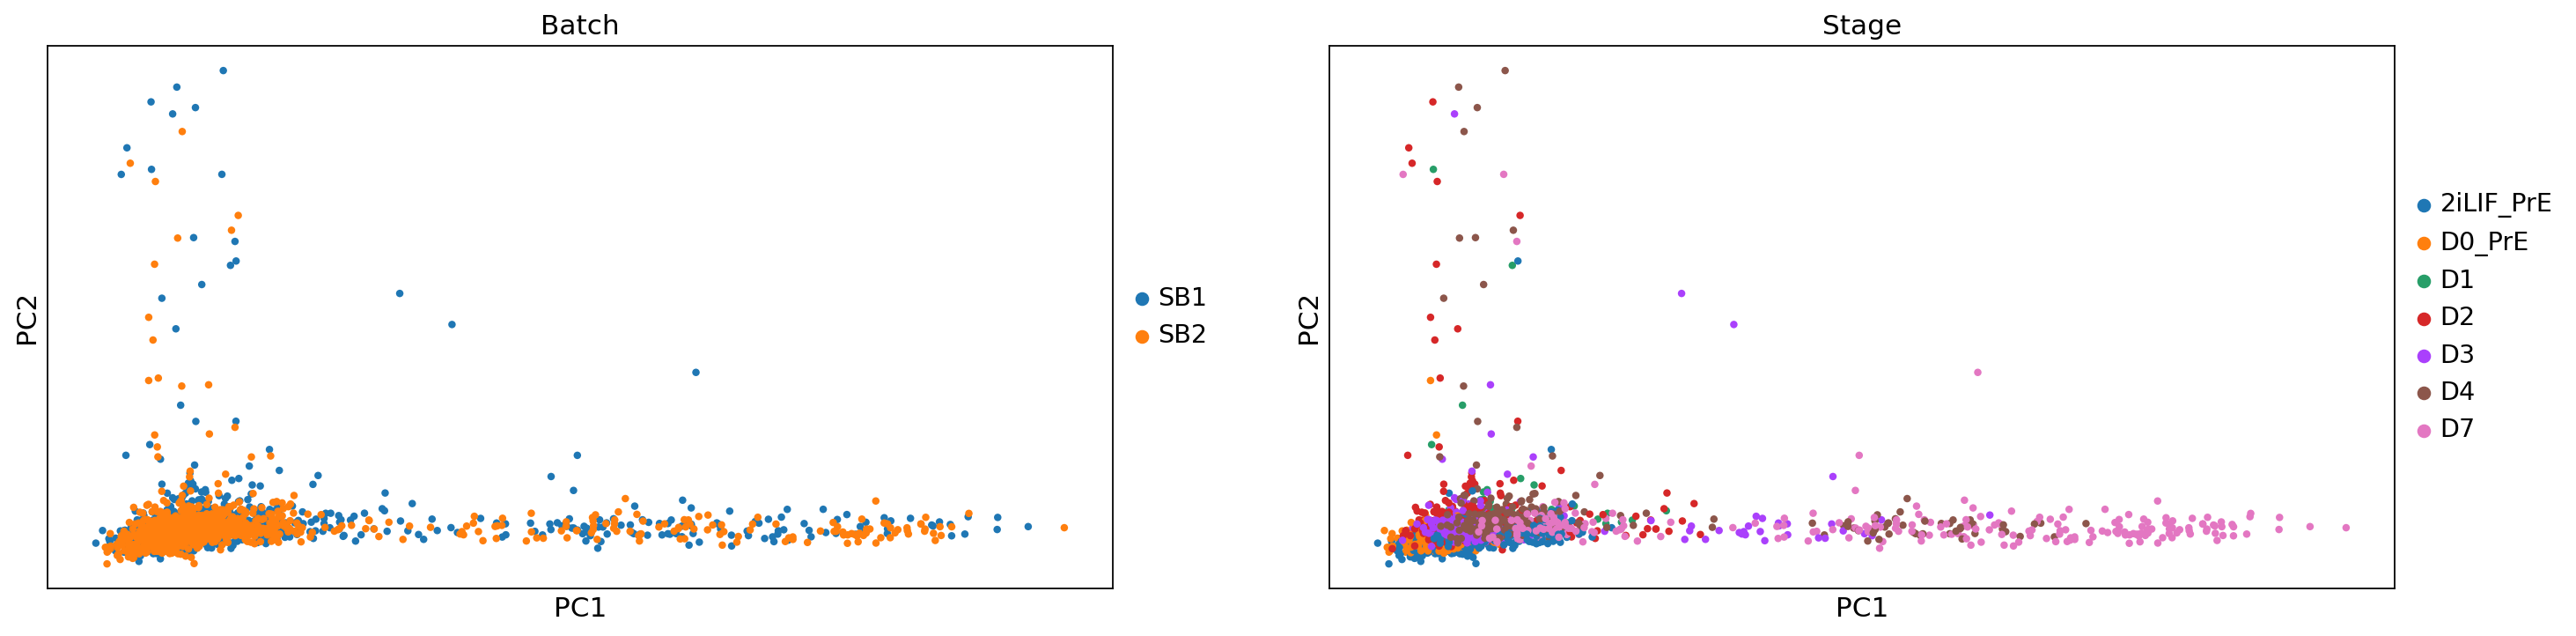

In [25]:
sc.pl.pca(adata, color=["Batch", "Stage"])

In [26]:
sc.pp.neighbors(adata, random_state=random_seed)
sc.tl.umap(adata, random_state=random_seed)
sc.tl.louvain(adata, random_state=random_seed)
sc.tl.leiden(adata, random_state=random_seed)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


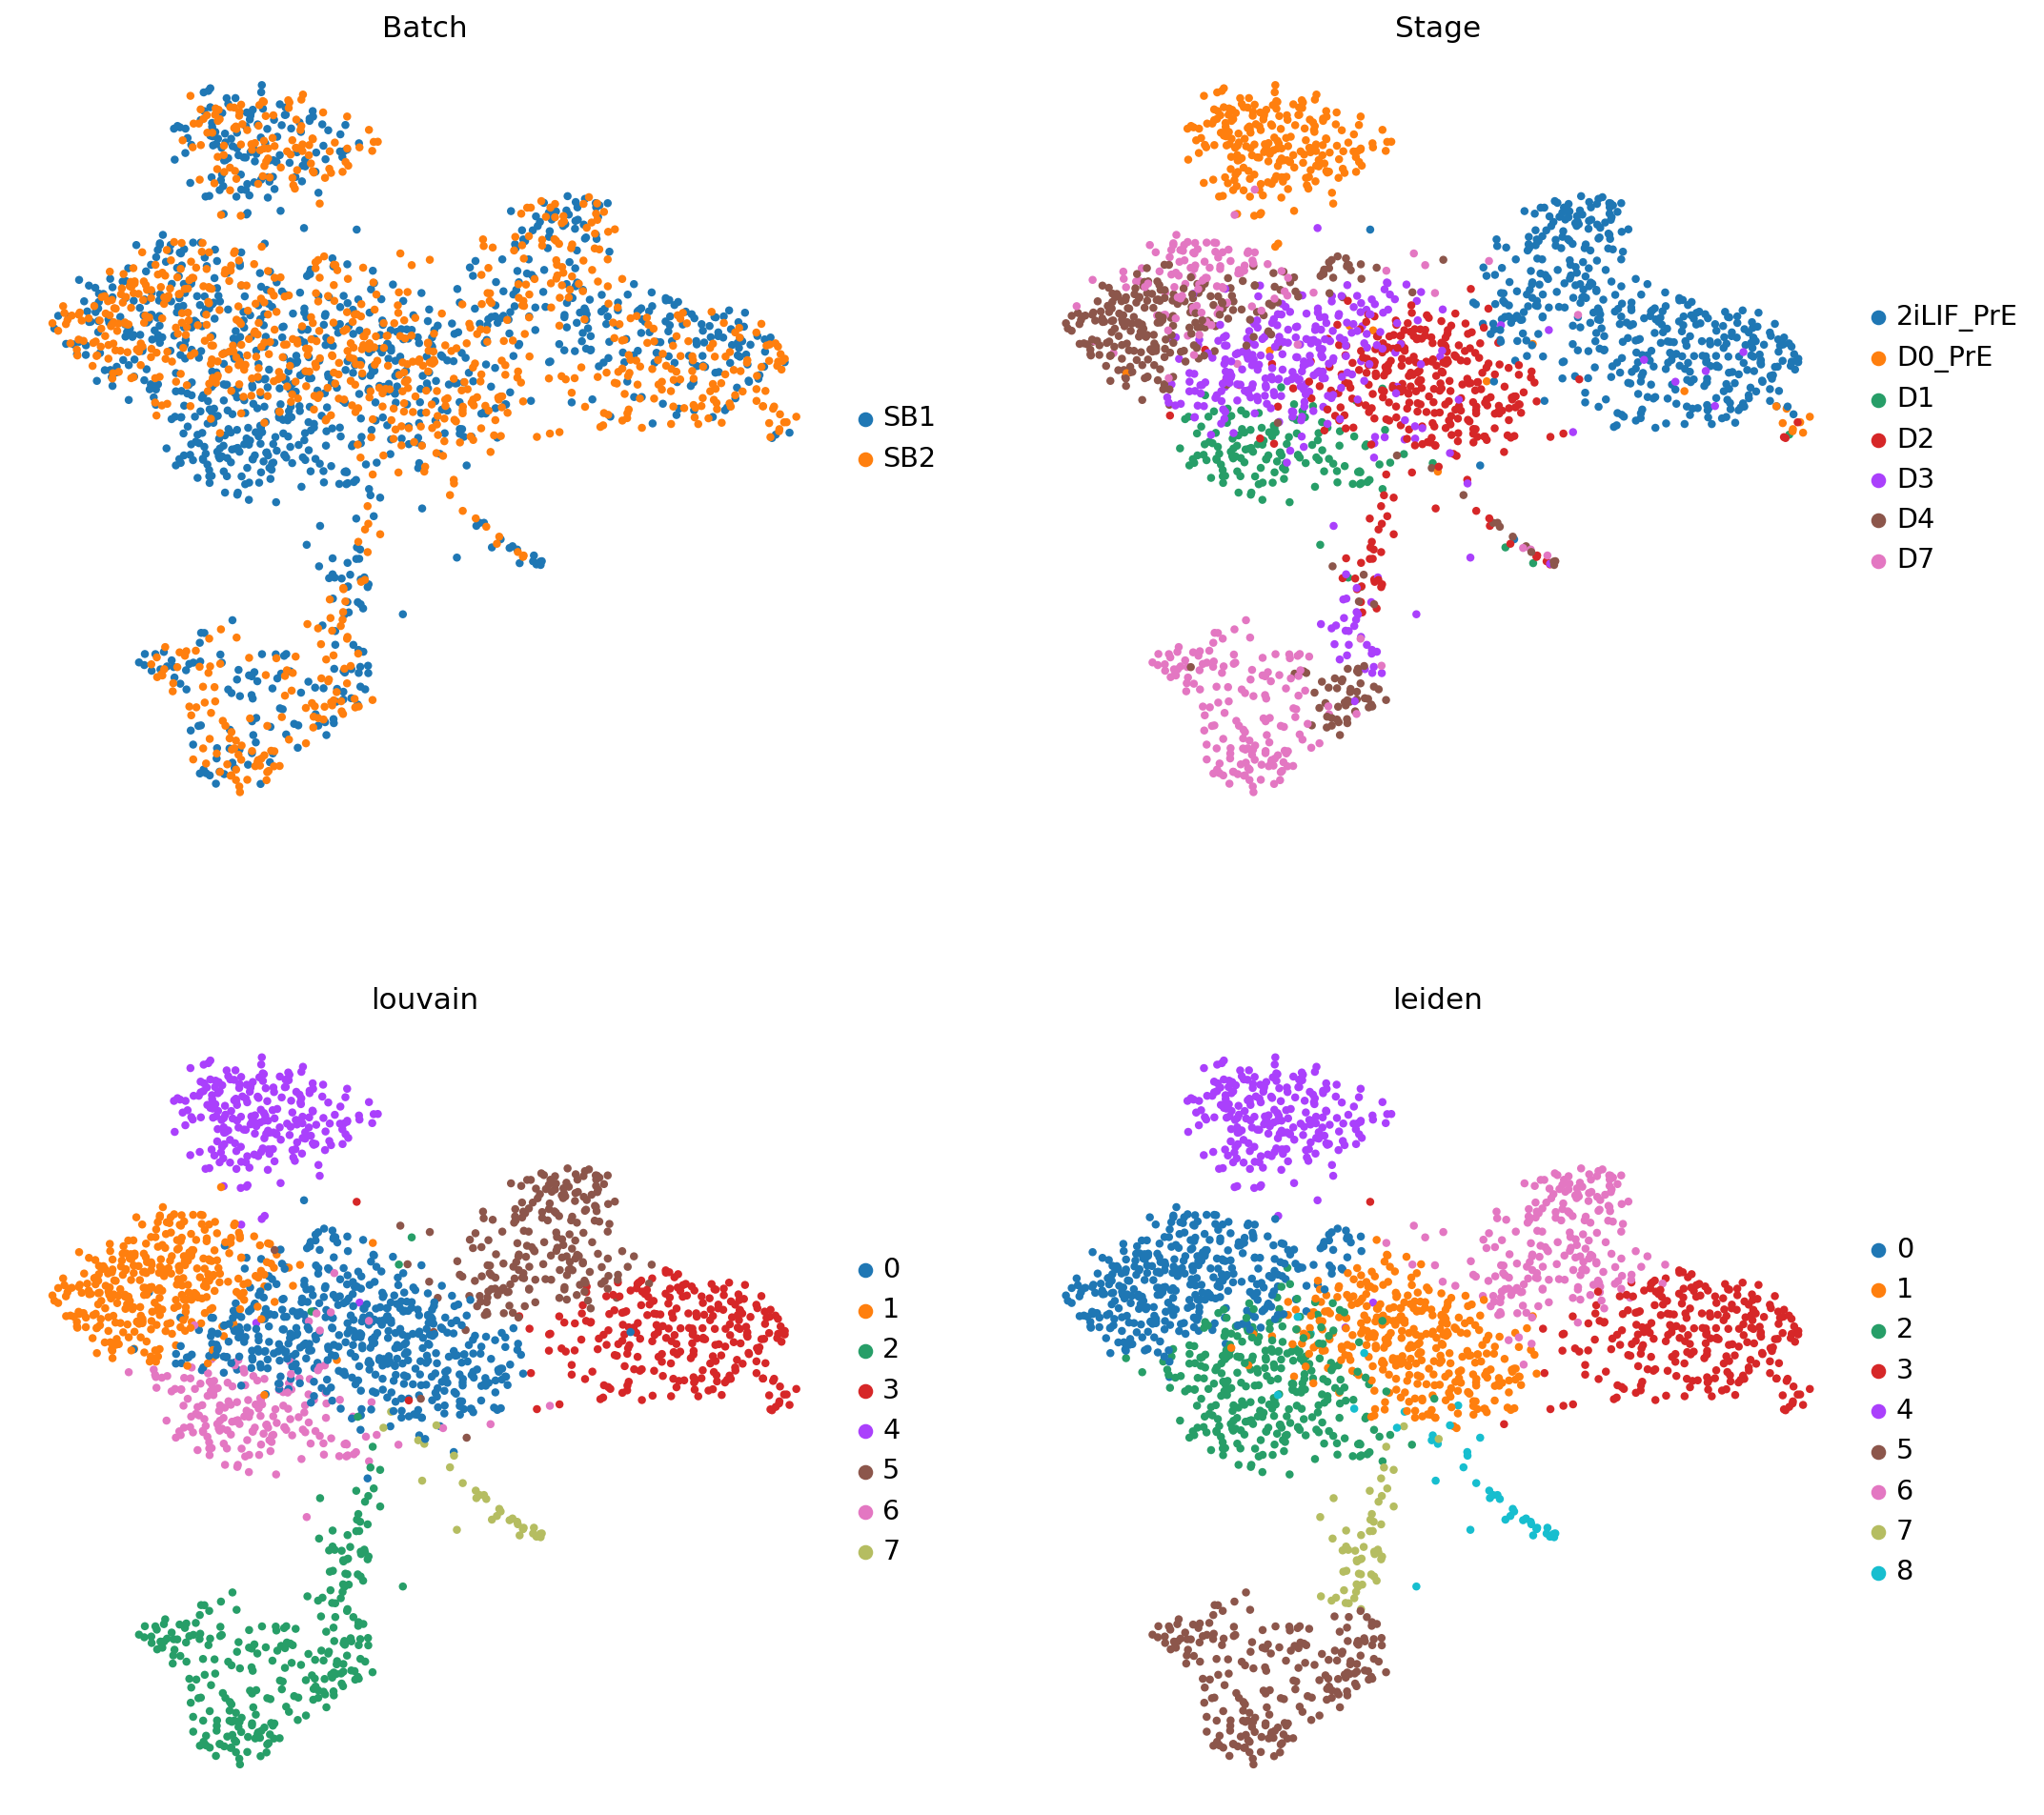

In [27]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata, color=['Batch', 'Stage', 'louvain', 'leiden'], ncols=2, frameon=False)

In [28]:
# Remove cluster 7
adata = adata[adata.obs.leiden != '8']

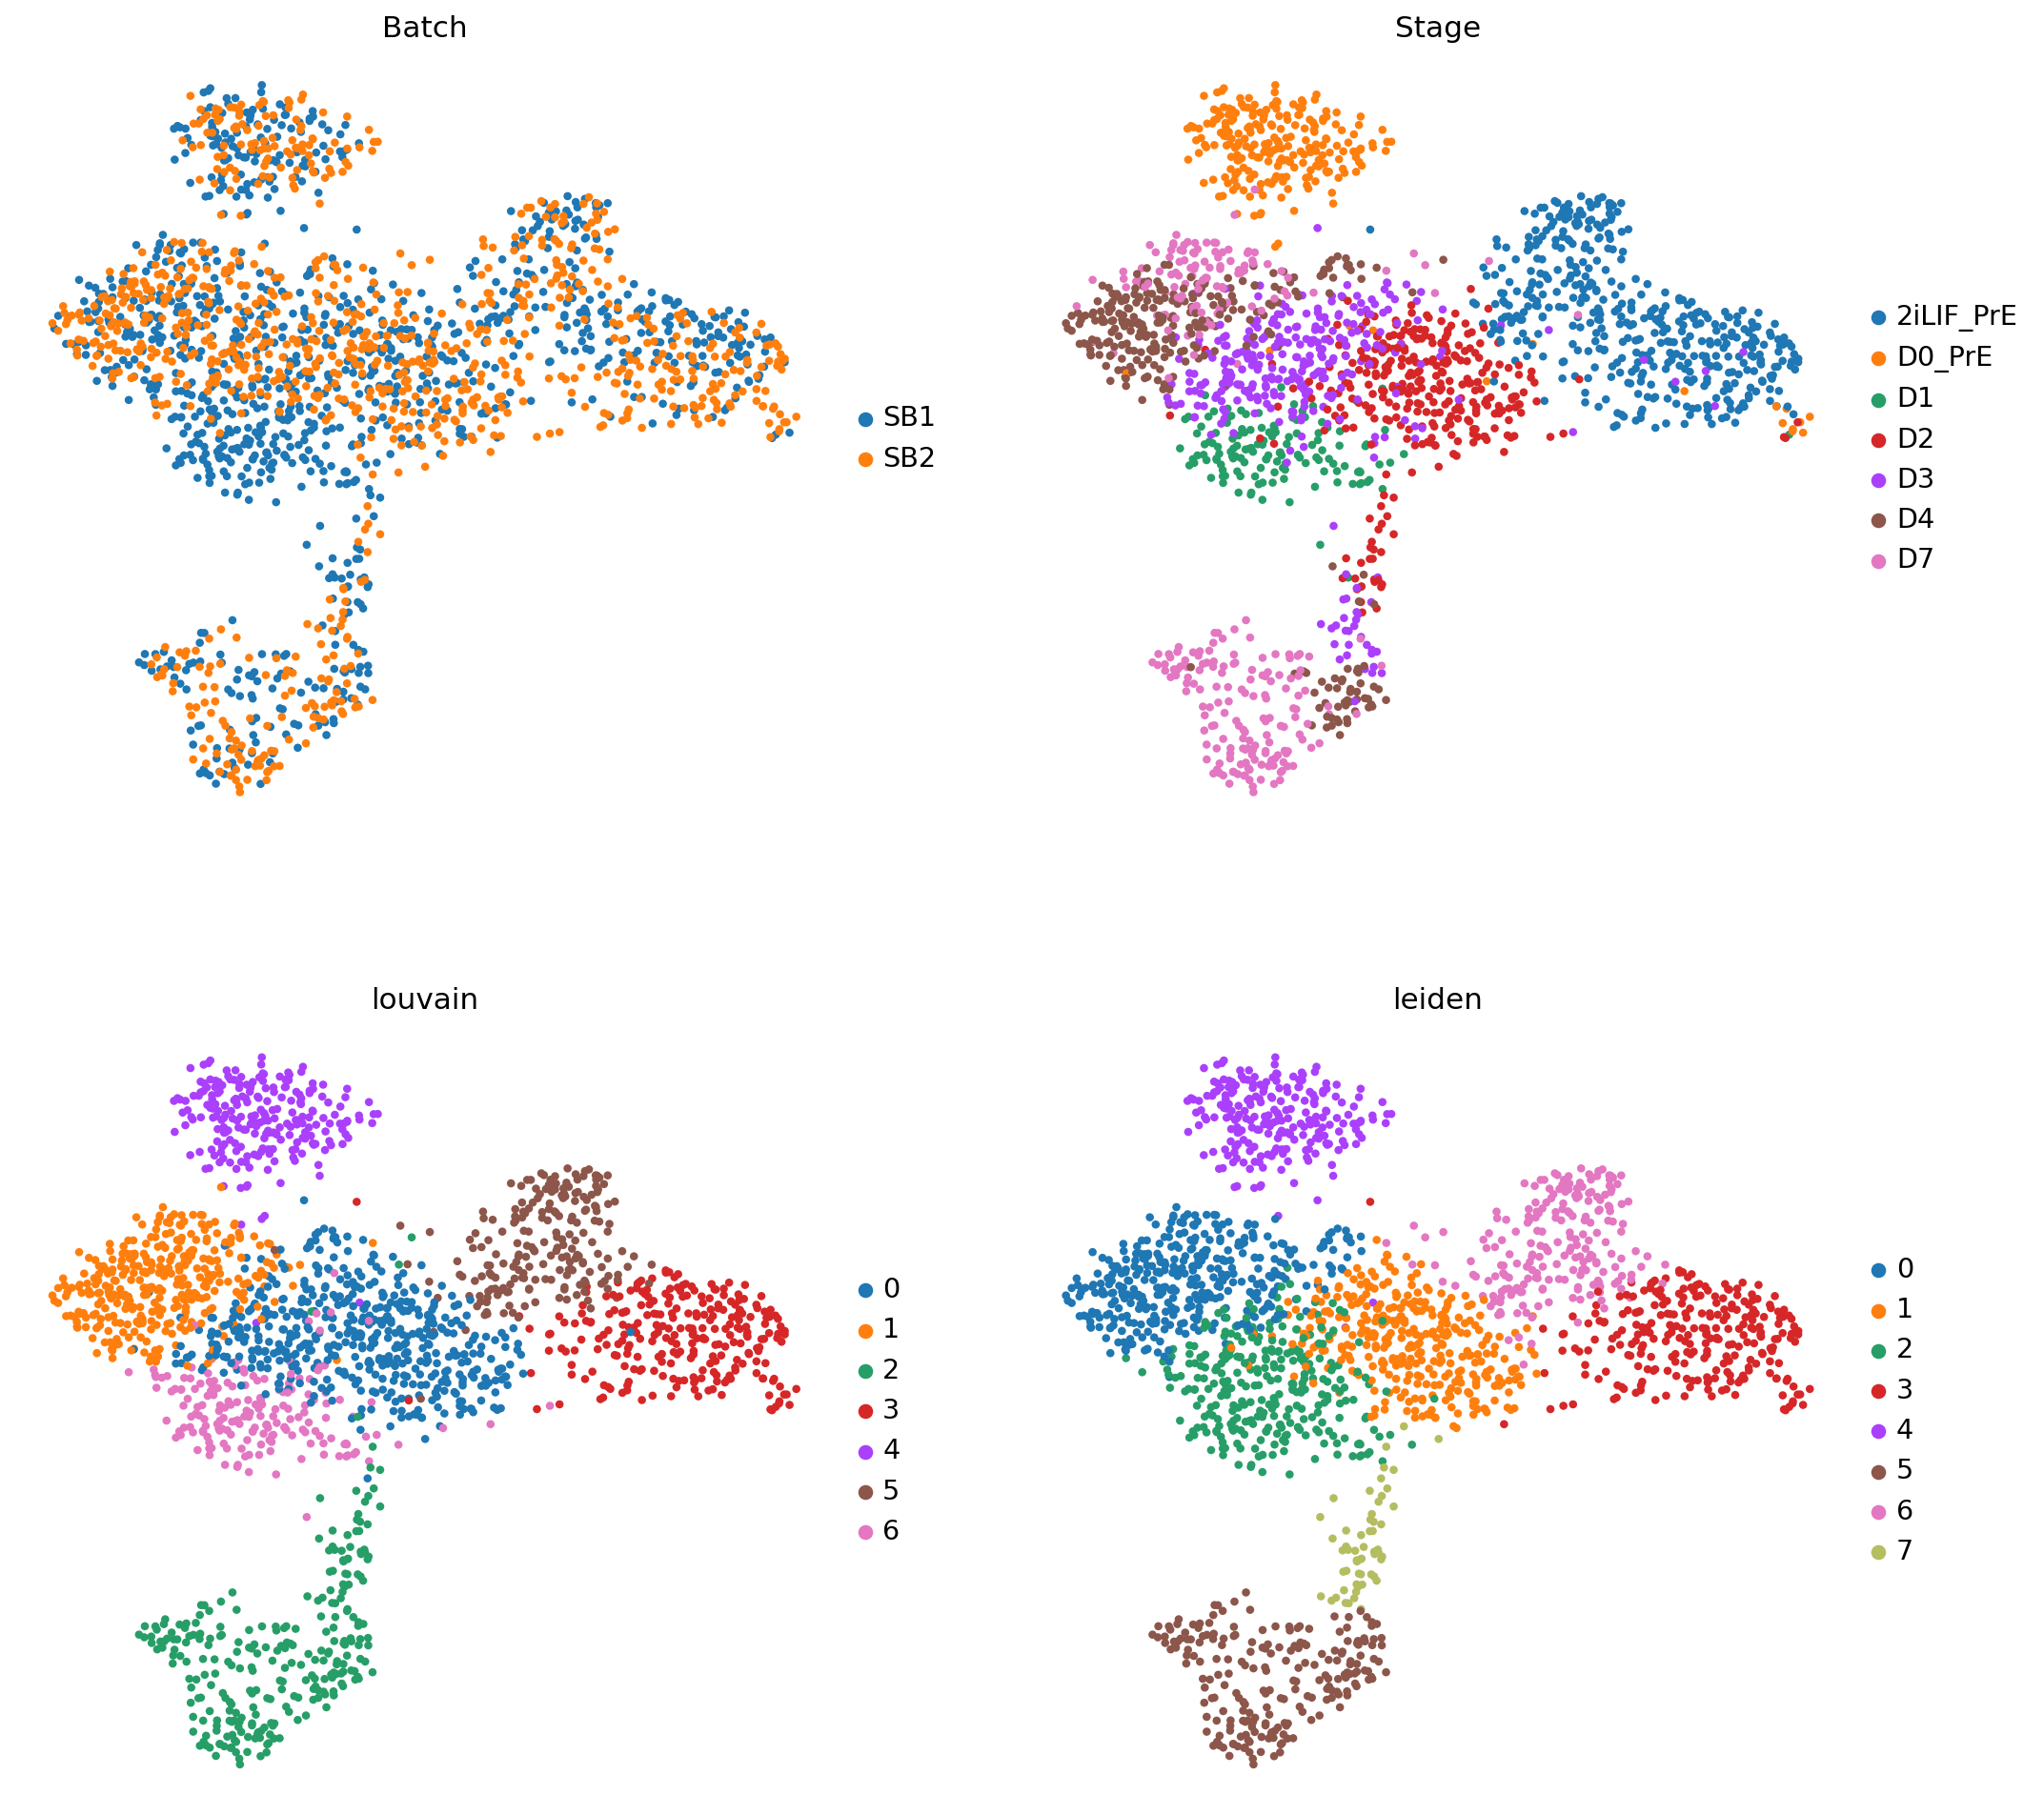

In [29]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata, color=['Batch', 'Stage', 'louvain', 'leiden'], ncols=2, frameon=False)

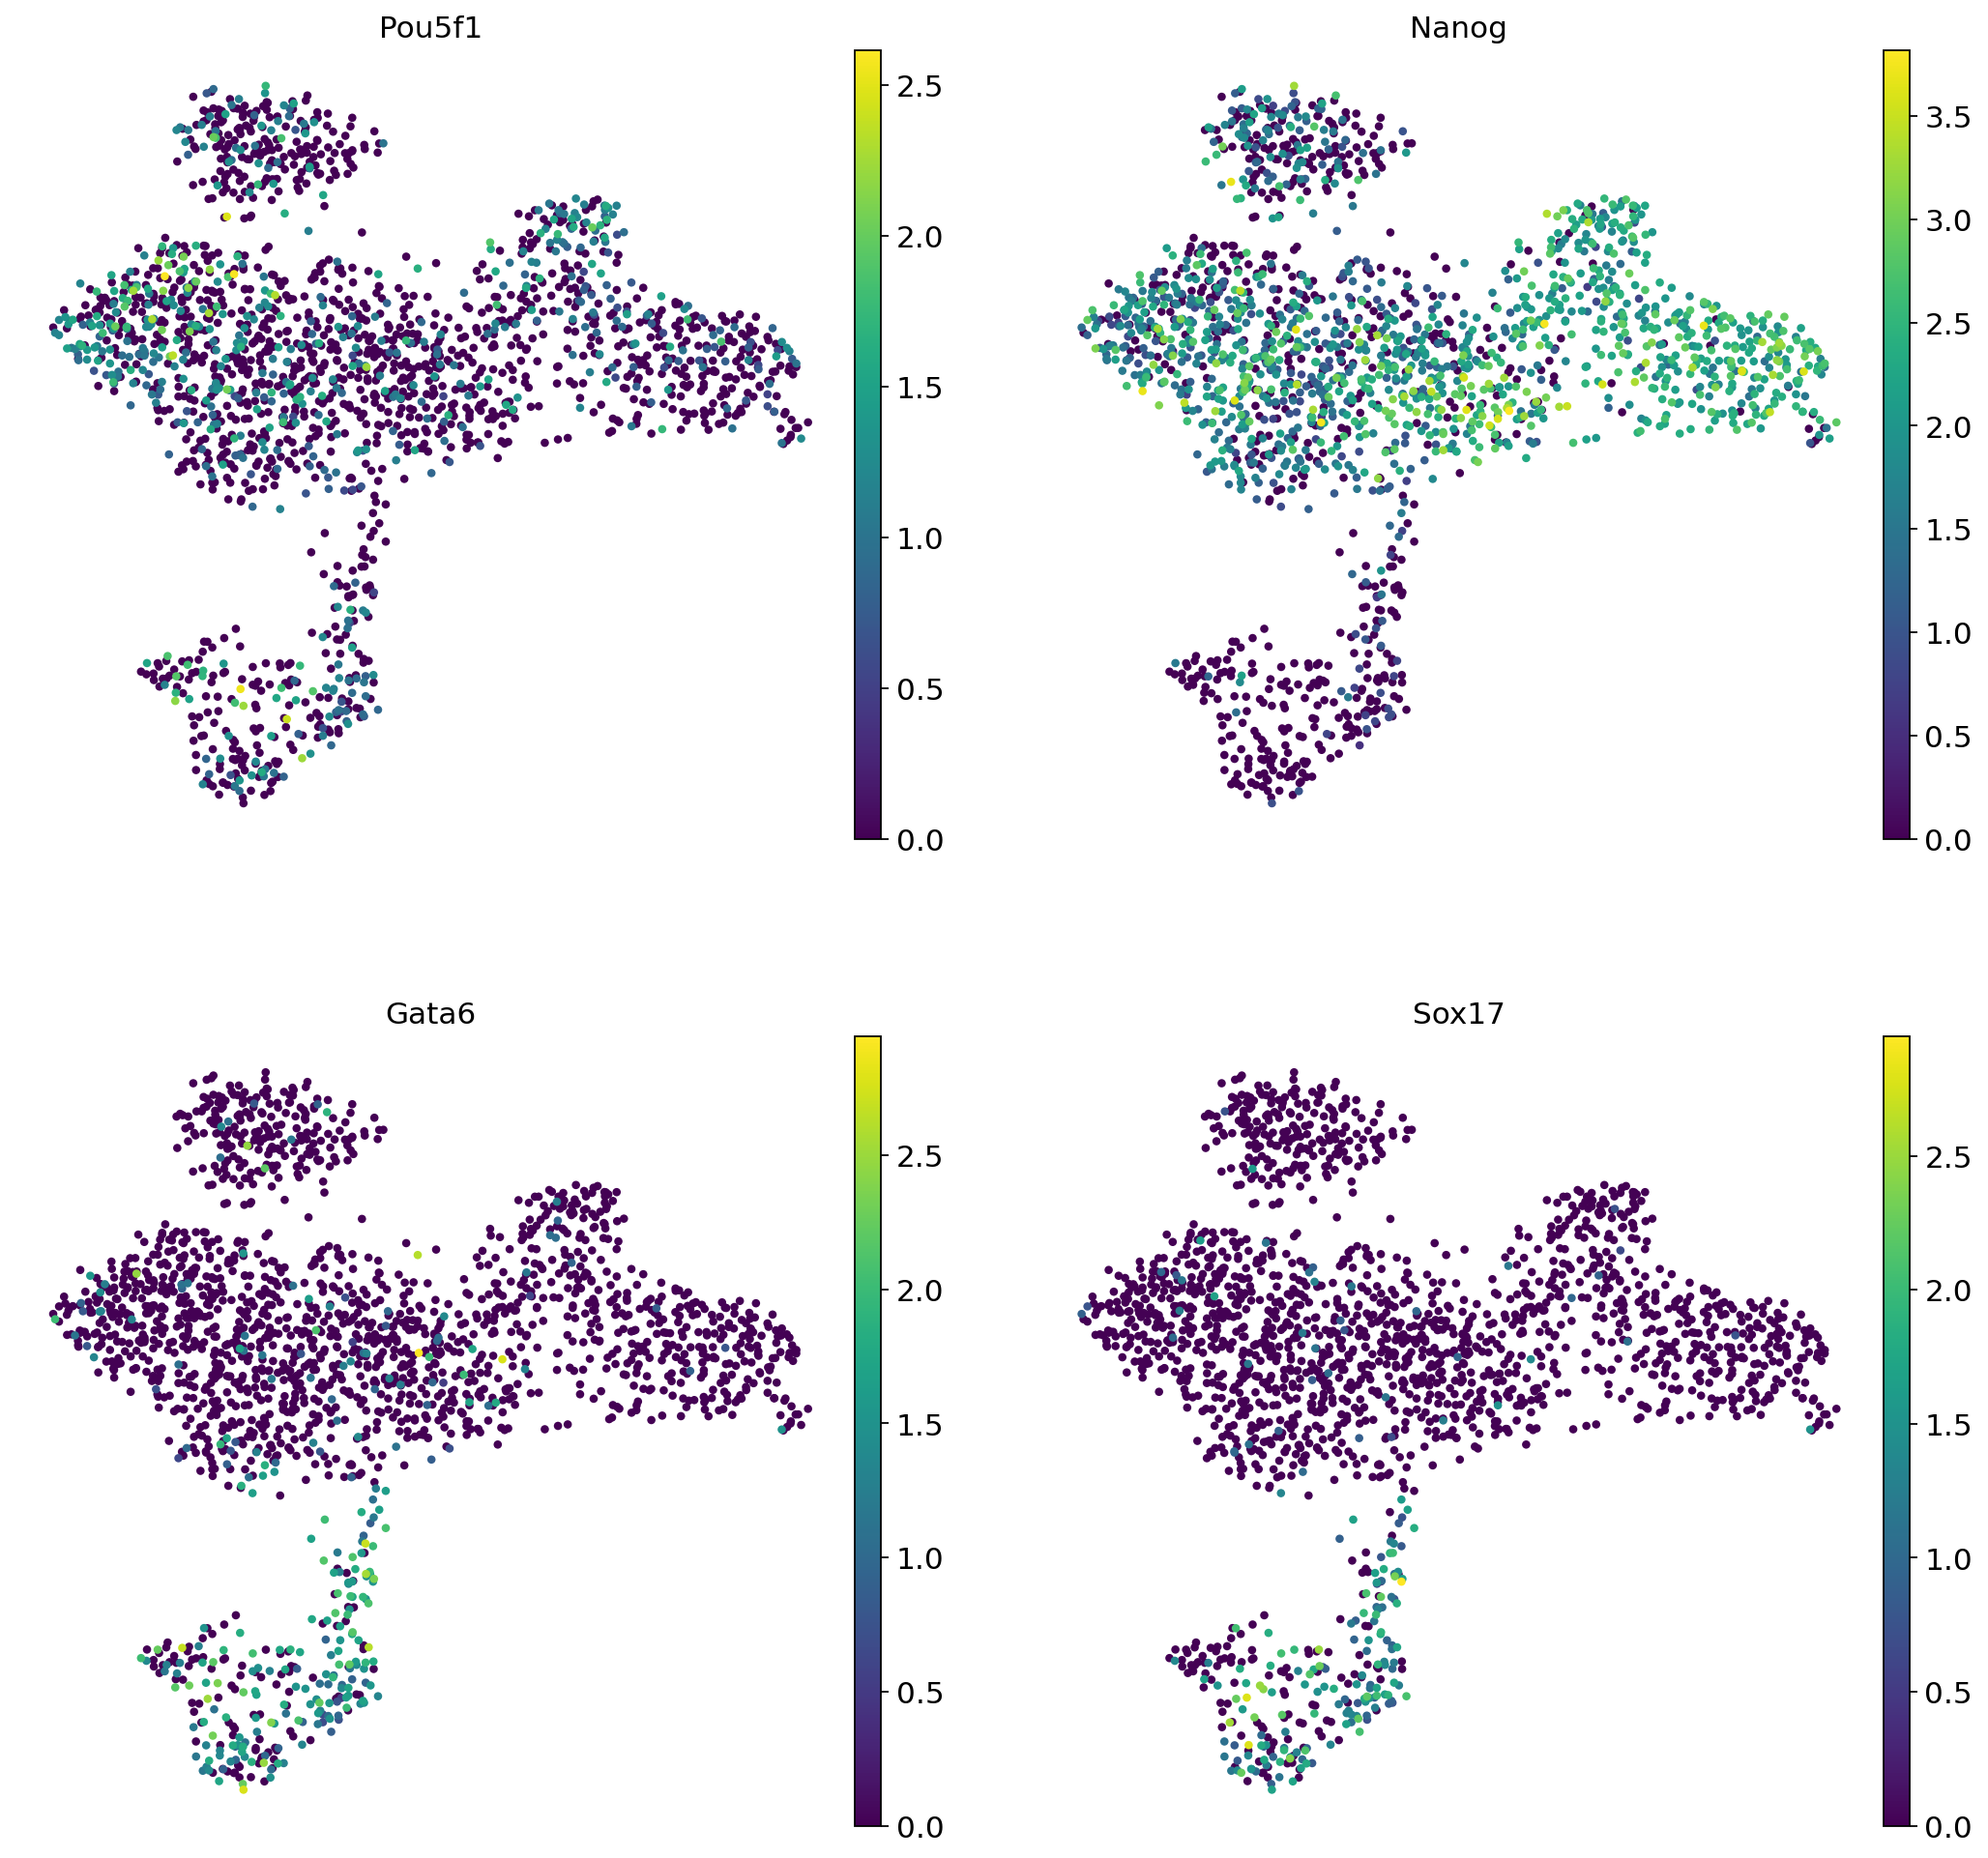

In [30]:
sc.pl.umap(adata, color=['Pou5f1', 'Nanog', 'Gata6', 'Sox17'], ncols=2, frameon=False)

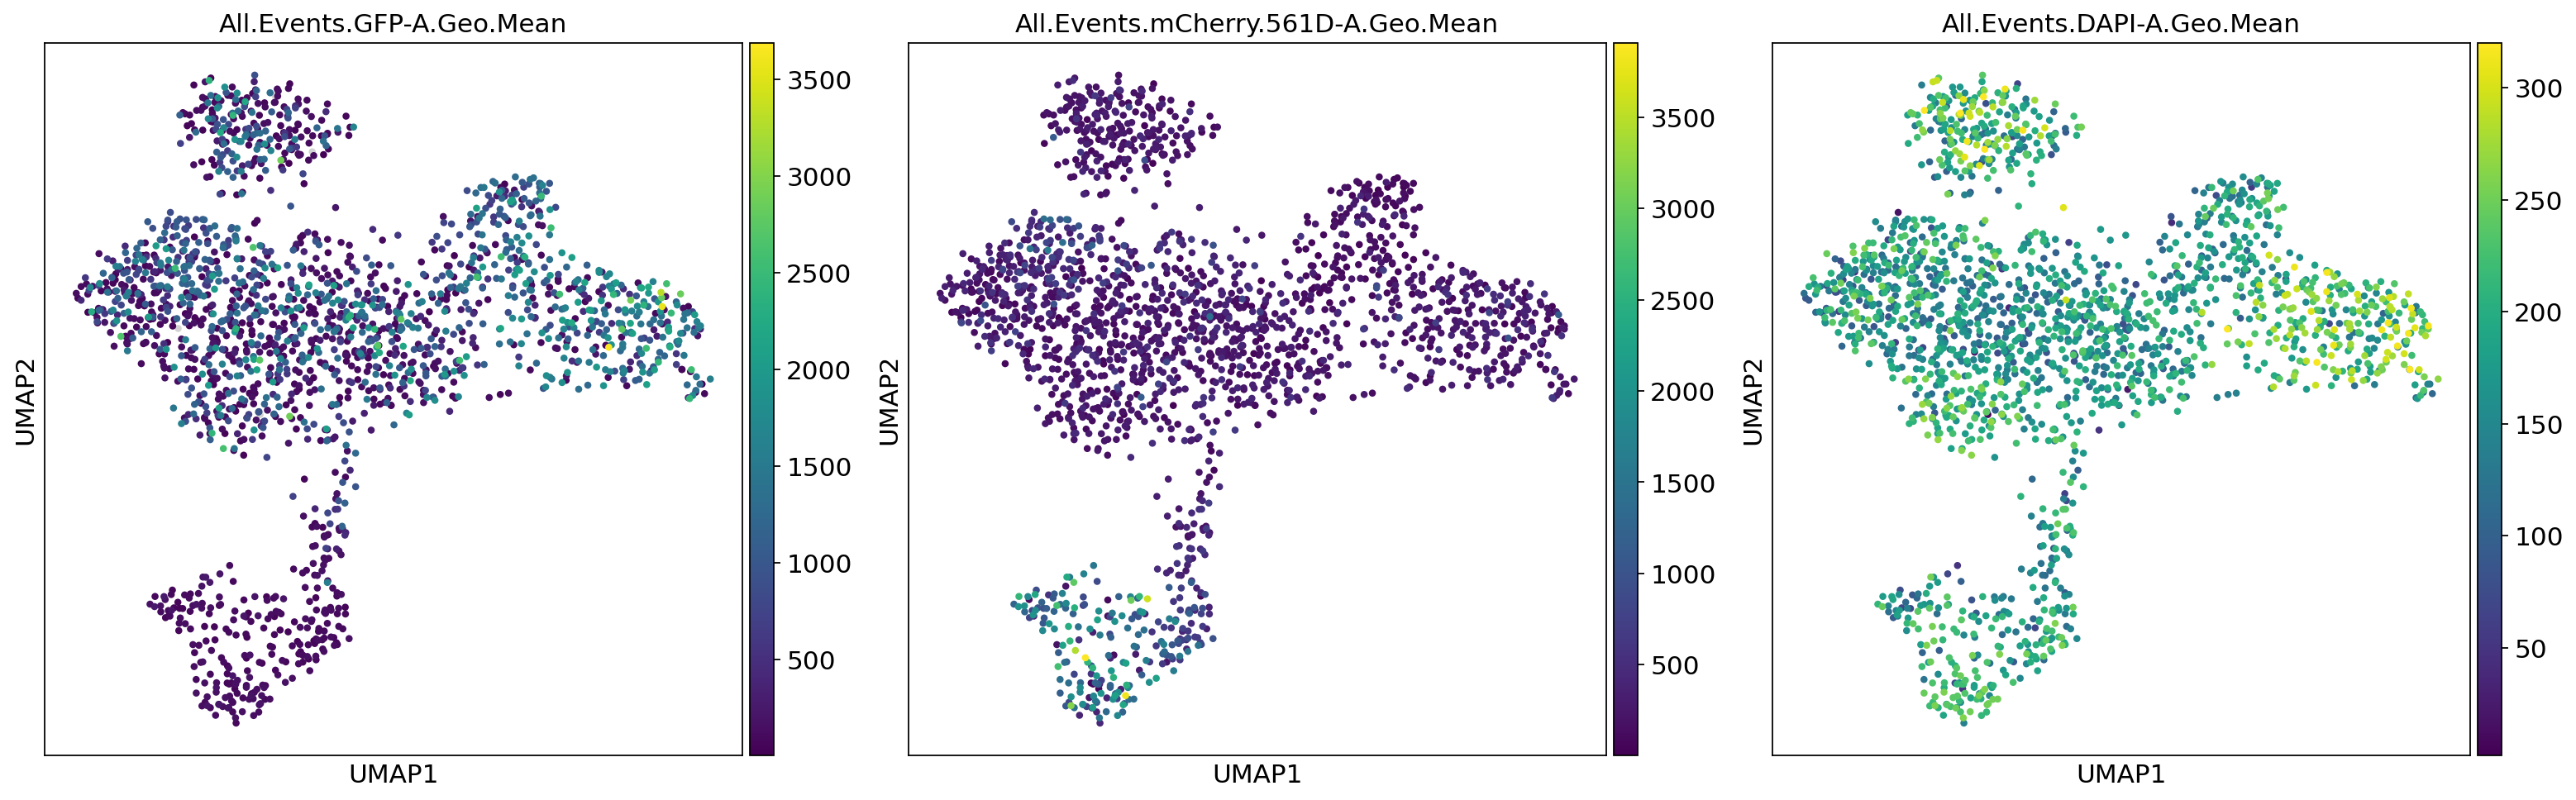

In [31]:
sc.pl.umap(adata, color=['All.Events.GFP-A.Geo.Mean', 
                         'All.Events.mCherry.561D-A.Geo.Mean',
                         'All.Events.DAPI-A.Geo.Mean'])

computing density on 'umap'


Trying to set attribute `.obs` of view, copying.


--> added
    'umap_density_Stage', densities (adata.obs)
    'umap_density_Stage_params', parameter (adata.uns)


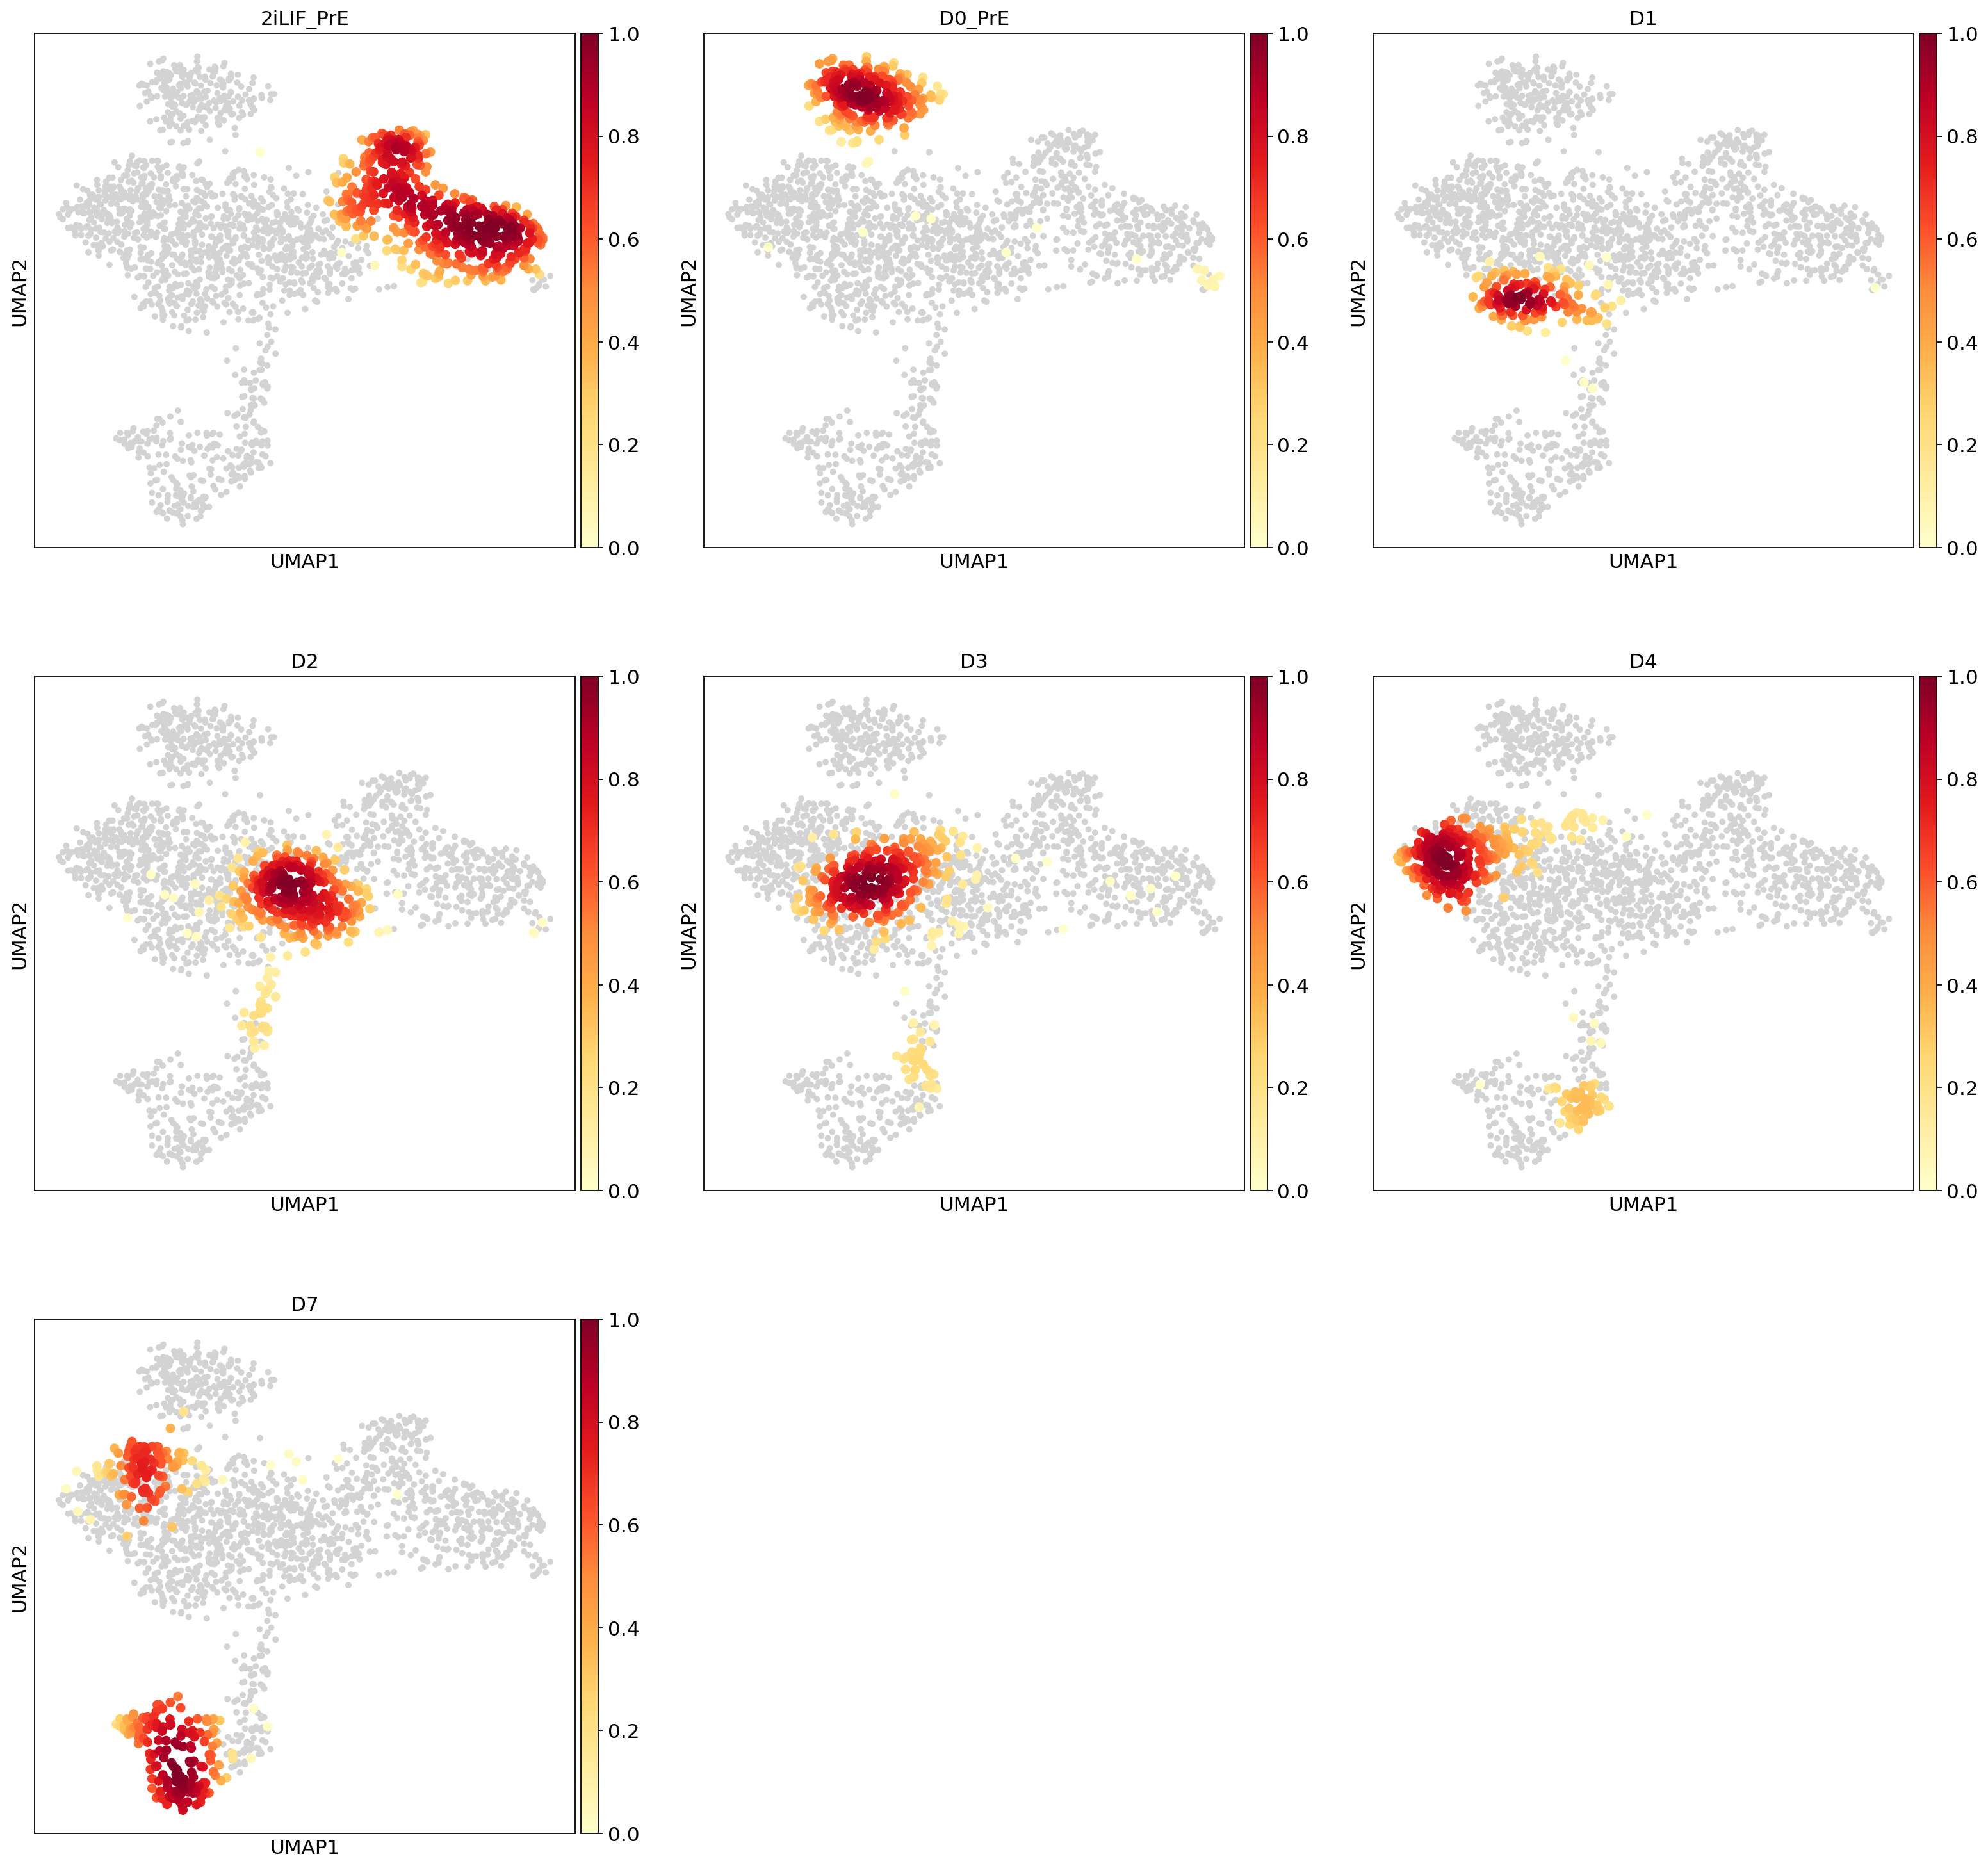

In [32]:
sc.tl.embedding_density(adata, basis='umap', groupby='Stage')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_Stage', ncols=3)

## Markers

In [33]:
sc.tl.rank_genes_groups(adata, groupby='leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


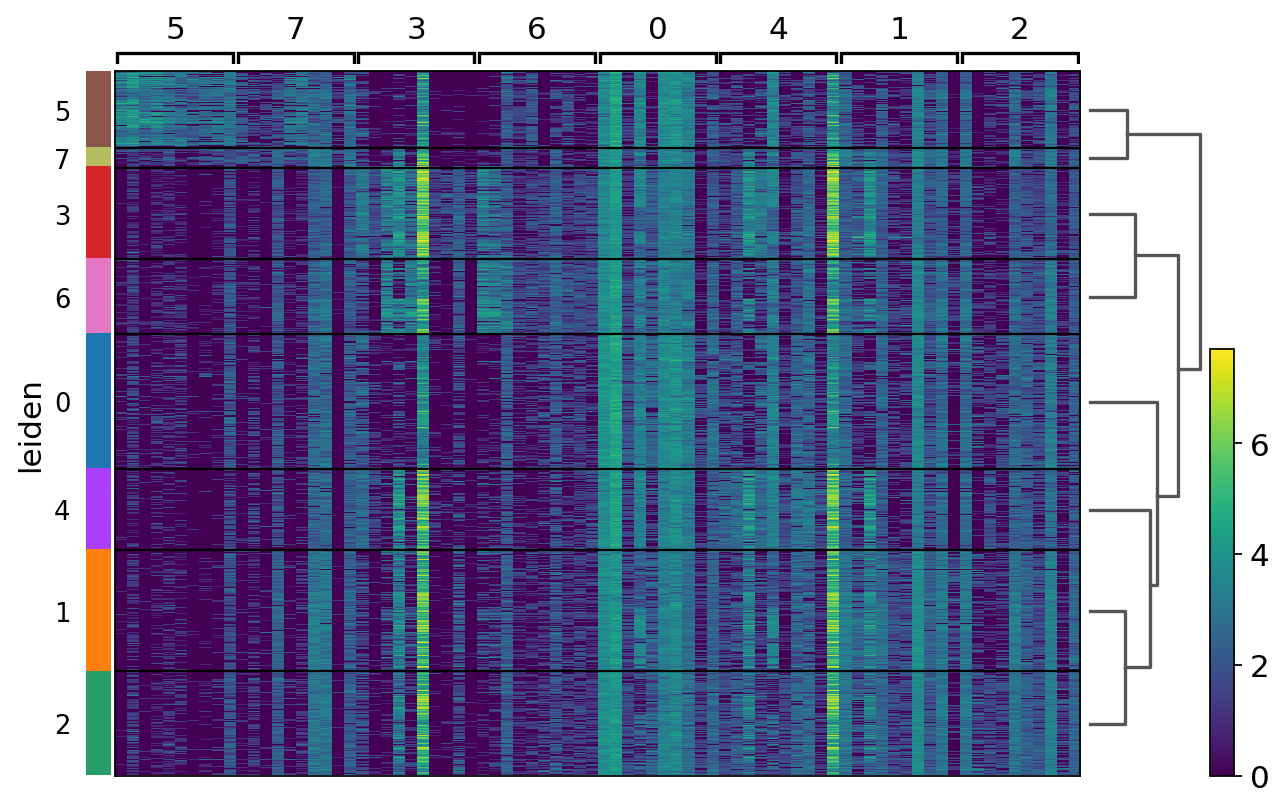

In [34]:
sc.tl.dendrogram(adata, groupby="leiden")
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10)

In [35]:
markers = []
for cluster in np.sort(adata.obs.leiden.unique()):
    df = sc.get.rank_genes_groups_df(adata, group=cluster, log2fc_min=1, pval_cutoff=0.05)
    df = df.sort_values(by='logfoldchanges', ascending=False).head(25)
    df['cluster'] = cluster
    markers.append(df)
markers = pd.concat(markers)
markers.to_csv("../results/01_louvain_markers.csv")

## Save session

In [36]:
adata.write("../data/processed/01_dataset.h5ad")

In [37]:
!jupyter nbconvert --to html 01_analysis.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 01_analysis.ipynb to html
[NbConvertApp] Writing 8519859 bytes to ../reports/01_analysis.html
